# Data loading, cleaning and exploration

We start with adding packages that we need for the task of data exploration. 

In [1]:
!pip install pandas
!pip install .\pycld2-0.41-cp39-cp39-win_amd64.whl
!pip install langdetect
!pip install matplotlib
!pip install pywsd
!pip install wordcloud
!pip install nltk
!pip install scikit-learn
!pip install tmtoolkit
!pip install gensim
!pip install pyLDAvis
!pip install seq2pat
!pip install prefixspan


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Processing c:\users\elina\documents\radboud\masters\research-internship\pycld2-0.41-cp39-cp39-win_amd64.whl
pycld2 is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, sys
path = os.path.join(os.path.abspath(""), 'internship-env', 'Lib', 'site-packages')
sys.path.append(path)

import glob
import json
import string
import math
import pandas as pd
import numpy as np
import re
import sklearn
from sklearn.model_selection import train_test_split
import random

import langdetect
import pycld2 as cld2

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

# Set random seed to 42
random.seed(42)

import re
import shlex
import keyword

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Elina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Define stop words
stop_words = stopwords.words('english')
process_latest_conversations = True

In [8]:
devgpt_location = "./DevGPT/"
github_devgpt_snapshot_folders = [path for path,_,_ in os.walk(devgpt_location) if "snapshot" in path]
commits_json_filepaths = []
issues_json_filepaths = []
discussion_json_filepaths = []
pull_requests_json_filepaths = []
code_json_filepaths = []
repo_json_filepaths = []
hackernews_json_filepaths = []

for snapshot_folder in github_devgpt_snapshot_folders:
    json_file_paths = glob.glob(f'{snapshot_folder}/*.json')
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "file" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_paths}' was not recognised!")

In [9]:
if process_latest_conversations:
    latest_data_path = "./latest_gpt_conversations/"
    json_file_paths = glob.glob(f'{latest_data_path}/*.json')
    for json_file_path in json_file_paths:
        if "commit" in json_file_path:
            commits_json_filepaths.append(json_file_path)
        elif "issue" in json_file_path:
            issues_json_filepaths.append(json_file_path)
        elif "discussion" in json_file_path:
            discussion_json_filepaths.append(json_file_path)
        elif "pr" in json_file_path:
            pull_requests_json_filepaths.append(json_file_path)
        elif "repo" in json_file_path:
            repo_json_filepaths.append(json_file_path)
        elif "file" in json_file_path:
            code_json_filepaths.append(json_file_path)
        elif "hn" in json_file_path:
            hackernews_json_filepaths.append(json_file_path)
        else:
            raise Exception(f"JSON file '{json_file_path}' was not recognised!")

""" Uncomment to print out all the file paths!
print(commits_json_filepaths)
print(issues_json_filepaths)
print(discussion_json_filepaths)
print(pull_requests_json_filepaths)
print(code_json_filepaths)
print(repo_json_filepaths)
print(hackernews_json_filepaths)"""

' Uncomment to print out all the file paths!\nprint(commits_json_filepaths)\nprint(issues_json_filepaths)\nprint(discussion_json_filepaths)\nprint(pull_requests_json_filepaths)\nprint(code_json_filepaths)\nprint(repo_json_filepaths)\nprint(hackernews_json_filepaths)'

We start with looking closely at what data is contained in the files and whether newer snapshots were just appended with new information, but contain old snapshot information as well, or they just contain information that was created after the last snapshot was combined. 

In [10]:
# ========================= Columns =========================
commit_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Sha', 'Message']
code_file_columns = ['Type', 'URL', 'RepoName']
repo_columns = ['Type', 'URL', 'RepoName', 'RepoLanguage']
issue_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'State']
pull_request_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'CreatedAt', 'ClosedAt', 'MergedAt', 'UpdatedAt', 'State', 'Additions', 'Deletions', 'ChangedFiles', 'CommitsTotalCount', 'CommitSha']
hacker_news_columns = ['Type', 'ID', 'URL', 'AttachedURL', 'Title', 'CreatedAt']
discussion_columns = ['Type', 'URL', 'Author', 'RepoName', 'RepoLanguage', 'Number', 'Title', 'Body', 'AuthorAt', 'ClosedAt', 'UpdatedAt', 'Closed', 'UpvoteCount']
mention_columns = ['MentionedURL', 'MentionedProperty', 'MentionedAuthor', 'MentionedText', 'MentionedPath','MentionedAnswer', 'MentionedUpvoteCount']
gpt_sharing_columns = ['SharingURL', 'Status', 'DateOfConversation', 'DateOfAccess', 'NumberOfPrompts', 'TokensOfPrompts', 'TokensOfAnswers', 'Model', 'Conversations']

# ========================= Processing functions =========================
def process_commit_json(commit):
    commit_array_of_elements = [commit[col] for col in commit_columns]
    return commit_array_of_elements

def process_code_files_json(code_file):
    code_files_array_of_elements = [code_file[col] for col in code_file_columns]
    return code_files_array_of_elements

def process_repo_json(repo):
    repo_array_of_elements = [repo[col] for col in repo_columns]
    return repo_array_of_elements
    
def process_issue_json(issue):
    issue_array_of_elements = [issue[col] if (col in issue) else "" for col in issue_columns]
    return issue_array_of_elements

def process_pull_request_json(pull_request):
    pull_request_array_of_elements = [pull_request[col] if (col in pull_request) else "" for col in pull_request_columns]
    return pull_request_array_of_elements

def process_hacker_news_json(hacker_news):
    hacker_news_array_of_elements = [hacker_news[col] for col in hacker_news_columns]
    return hacker_news_array_of_elements

def process_discussion_json(discussion):
    discussion_array_of_elements = [discussion[col] if (col in discussion) else "" for col in discussion_columns]
    return discussion_array_of_elements

def process_sharing_json(sharing):
    gptsharing_array_of_elements = [sharing['URL']]
    gptsharing_array_of_elements += [sharing[col] for col in gpt_sharing_columns[1:]]
    mention = sharing['Mention']
    gptsharing_array_of_elements += [mention[col] if (col in mention) else "" for col in mention_columns]
    return gptsharing_array_of_elements

In [11]:
def process_file_content(data, filepath):
    df_data = []
    sources = data['Sources'] if 'DevGPT' in filepath else data
    for source in sources:
        source_array = []
        df_columns = []
        if source['Type'] == 'commit':
            source_array = process_commit_json(source)
            df_columns = commit_columns
        elif source['Type'] == 'code file':
            source_array = process_code_files_json(source)
            df_columns = code_file_columns
        elif source['Type'] == 'repository':
            source_array = process_repo_json(source)
            df_columns = repo_columns
        elif source['Type'] == 'issue':
            source_array = process_issue_json(source)
            df_columns = issue_columns
        elif source['Type'] == 'pull request':
            source_array = process_pull_request_json(source)
            df_columns = pull_request_columns
        elif source['Type'] == 'hacker news':
            source_array = process_hacker_news_json(source)
            df_columns = hacker_news_columns
        elif source['Type'] == 'discussion':
            source_array = process_discussion_json(source)
            df_columns = discussion_columns
        else:
            print(f"Unexpected type of the course: '{source['Type']}'")
            raise
        for sharing in source['ChatgptSharing']:
            if sharing['Status'] != 200:
                continue
            sharing_array = process_sharing_json(sharing)
            df_data.append(source_array + sharing_array)
    return df_data, df_columns

def read_json_data_from_files_to_dataframe(filepaths_list):
    file_sharings_df = pd.DataFrame()
    devgpt_extended_with_x_files = 1
    devgpt_filepaths_idx = -(devgpt_extended_with_x_files) if process_latest_conversations else 0
    # Only process DevGPT conversations in the for-loop
    for json_filepath in filepaths_list[:devgpt_filepaths_idx]:
        with open(json_filepath, 'r') as file:
            # Load JSON data from file
            json_data = json.load(file)
            data_to_df, columns_for_df = process_file_content(json_data, json_filepath)
            file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df + gpt_sharing_columns + mention_columns)
            file_dataframe['NumberOfPrompts'] = file_dataframe['Conversations'].apply(lambda x : int(len(x)))
            print(f"Data from '{json_filepath}' file contains {len(file_dataframe)} elements.")
            file_sharings_df = pd.concat([file_sharings_df, file_dataframe])
    print(f"When all the DevGPT dataframes were concatenated/appended, we have total of {len(file_sharings_df)} rows in the DF.")
    file_sharings_df = file_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last').reset_index(drop=True)
    print(f"After removing duplicates from DevGPT based on ChatGPT URL of the source, we have total of {len(file_sharings_df)} rows in the DF.")
    if process_latest_conversations:
        extension_filepaths = filepaths_list[-(devgpt_extended_with_x_files):]
        extension_sharings_df = pd.DataFrame()
        for json_filepath in extension_filepaths:
            with open(json_filepath, 'r') as file:
                # Load JSON data from file
                json_data = json.load(file)
                data_to_df, columns_for_df = process_file_content(json_data, json_filepath)
                file_dataframe = pd.DataFrame(data_to_df, columns=columns_for_df + gpt_sharing_columns + mention_columns)
                print(f"Data from '{json_filepath}' file contains {len(file_dataframe)} elements.")
                extension_sharings_df = pd.concat([extension_sharings_df, file_dataframe])
        extension_sharings_df = extension_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last').reset_index(drop=True)
        print(f"After removing duplicates from extension dataset based on ChatGPT URL of the source, we have total of {len(extension_sharings_df)} rows in the DF.")
        file_sharings_df = pd.concat([file_sharings_df, extension_sharings_df])
        file_sharings_df = file_sharings_df.drop_duplicates(subset=['SharingURL'], keep='last').reset_index(drop=True)
        print(f"After removing duplicates (incl. DevGPT extension) based on ChatGPT URL of the source, we have total of {len(file_sharings_df)} rows in the DF.")
    return file_sharings_df

In [12]:
# 670 sharings
commits_dataframe = read_json_data_from_files_to_dataframe(commits_json_filepaths)
commits_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200003_commit_sharings.json' file contains 178 elements.
Data from './DevGPT/snapshot_20230803\20230803_095317_commit_sharings.json' file contains 214 elements.
Data from './DevGPT/snapshot_20230810\20230810_124807_commit_sharings.json' file contains 301 elements.
Data from './DevGPT/snapshot_20230817\20230817_131244_commit_sharings.json' file contains 198 elements.
Data from './DevGPT/snapshot_20230824\20230824_102435_commit_sharings.json' file contains 199 elements.
Data from './DevGPT/snapshot_20230831\20230831_063412_commit_sharings.json' file contains 477 elements.
Data from './DevGPT/snapshot_20230907\20230907_110036_commit_sharings.json' file contains 398 elements.
Data from './DevGPT/snapshot_20230914\20230914_083202_commit_sharings.json' file contains 568 elements.
Data from './DevGPT/snapshot_20230914\.ipynb_checkpoints\20230914_083202_commit_sharings-checkpoint.json' file contains 568 elements.
Data from './DevGPT/snapshot_20231

,Type,URL,Author,RepoName,RepoLanguage,Sha,Message,SharingURL,Status,DateOfConversation,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,commit,https://github.com/Hamza-Eng/baldie/commit/3a7...,Hamza-Eng,Hamza-Eng/baldie,Blade,3a7364f2ab5e67c80aa4f61f644f315e4b233390,add facebook pixel\n\nfor more information you...,https://chat.openai.com/share/e6c824b7-bf94-4b...,200,"July 21, 2023",...,2097,,"[{'Prompt': 'add facebook pixel to laravel ', ...",https://github.com/Hamza-Eng/baldie/commit/3a7...,message,Hamza-Eng,add facebook pixel\n\nfor more information you...,,,
1,commit,https://github.com/jdustinwilliams/hibddbs/com...,dzdn,jdustinwilliams/hibddbs,CSS,e6a01ec078e950a277e7caa21affd7c4ae23d244,Make advanced search concise\n\nUsed ChatGPT f...,https://chat.openai.com/share/e476a2d0-5c29-4c...,200,"August 22, 2023",...,1067,Default,[{'Prompt': 'Is there a way I could make this ...,https://github.com/jdustinwilliams/hibddbs/com...,message,dzdn,Make advanced search concise\n\nUsed ChatGPT f...,,,
2,commit,https://github.com/grnpin/textbox/commit/fa335...,grnpin,grnpin/textbox,HTML,fa335cf2ec447d00f8e94b54a8b463725b92947c,https://chat.openai.com/share/4bad57dd-9636-4b...,https://chat.openai.com/share/4bad57dd-9636-4b...,200,"September 20, 2023",...,556,Default (GPT-3.5),[{'Prompt': 'このコードだと、スマートフォンでキーボードを表示したときにbutt...,https://github.com/grnpin/textbox/commit/fa335...,message,grnpin,https://chat.openai.com/share/4bad57dd-9636-4b...,,,
3,commit,https://github.com/grnpin/textbox/commit/0dfc4...,grnpin,grnpin/textbox,HTML,0dfc4385b723060e1e6a21da17a952bd908084ff,https://chat.openai.com/share/1fd7ffc2-9264-45...,https://chat.openai.com/share/1fd7ffc2-9264-45...,200,"September 9, 2023",...,160,Default,[{'Prompt': 'このコードなんですが、Placeholder上でちゃんと改行するコ...,https://github.com/grnpin/textbox/commit/0dfc4...,message,grnpin,https://chat.openai.com/share/1fd7ffc2-9264-45...,,,
4,commit,https://github.com/grnpin/textbox/commit/811d0...,grnpin,grnpin/textbox,HTML,811d09acdca361c81281c7d71587ebdbd8437453,https://chat.openai.com/share/99d2d02f-7e3b-43...,https://chat.openai.com/share/99d2d02f-7e3b-43...,200,"September 7, 2023",...,115,Default,[{'Prompt': 'refactor this code. <!DOCTYPE ht...,https://github.com/grnpin/textbox/commit/811d0...,message,grnpin,https://chat.openai.com/share/99d2d02f-7e3b-43...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891,commit,https://github.com/bpbpublications/Modern-Pyth...,gshiva,bpbpublications/Modern-Python-Programming-usin...,Python,3adeb8a3e25142cf93ff5fe584b83d86ebab22e3,"Completes Unit,Integration, System and Accept...",https://chat.openai.com/share/ed5cf830-e99a-47...,200,"December 26, 2023",...,8467,GPT-3.5,[{'Prompt': 'How to get rid of this warning? ...,https://github.com/bpbpublications/Modern-Pyth...,message,gshiva,"Completes Unit,Integration, System and Accept...",,,
892,commit,https://github.com/bpbpublications/Modern-Pyth...,gshiva,bpbpublications/Modern-Python-Programming-usin...,Python,3adeb8a3e25142cf93ff5fe584b83d86ebab22e3,"Completes Unit,Integration, System and Accept...",https://chat.openai.com/share/2ab02c29-ed15-45...,200,"December 26, 2023",...,11896,GPT-3.5,[{'Prompt': 'All these code have no tests. I w...,https://github.com/bpbpublications/Modern-Pyth...,message,gshiva,"Completes Unit,Integration, System and Accept...",,,
893,commit,https://github.com/fel-dev/Aprenda-BDD-com-Cuc...,Felipe Carneiro,fel-dev/Aprenda-BDD-com-Cucumber-em-JAVA,Java,1e040e6b9932930ffdb27966177c53aa803959f5,Exprecoes Regulares\n\n12. Reaproveitando cená...,https://chat.openai.com/share/1bb2f0db-2ef8-49...,200,"December 27, 2023",...,1024,GPT-3.5,"[{'Prompt': 'expressÃ£o regular para data', 'A...",https://github.com/fel-dev/Aprenda-BDD-com-Cuc...,message,Felipe Carneiro,Exprecoes Regulares\n\n12. Reaproveitando cená...,,,
894,commit,https://github.com/Arushan2/Canvas

In [13]:
# 516
issues_dataframe = read_json_data_from_files_to_dataframe(issues_json_filepaths)
issues_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195941_issue_sharings.json' file contains 243 elements.
Data from './DevGPT/snapshot_20230803\20230803_094705_issue_sharings.json' file contains 264 elements.
Data from './DevGPT/snapshot_20230810\20230810_123938_issue_sharings.json' file contains 306 elements.
Data from './DevGPT/snapshot_20230817\20230817_130502_issue_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20230824\20230824_101836_issue_sharings.json' file contains 369 elements.
Data from './DevGPT/snapshot_20230831\20230831_061759_issue_sharings.json' file contains 384 elements.
Data from './DevGPT/snapshot_20230907\20230907_092956_issue_sharings.json' file contains 419 elements.
Data from './DevGPT/snapshot_20230914\20230914_080417_issue_sharings.json' file contains 503 elements.
Data from './DevGPT/snapshot_20231012\20231012_235128_issue_sharings.json' file contains 598 elements.
When all the DevGPT dataframes were concatenated/appended, we have total 

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,issue,https://github.com/relaycorp/terraform-google-...,gnarea,relaycorp/terraform-google-awala-endpoint,HCL,4,Run bootstrapping job automatically every time...,See:\r\n\r\n- https://chat.openai.com/share/71...,,None,...,694,Default,[{'Prompt': 'I'm using Terraform to manage som...,https://github.com/relaycorp/terraform-google-...,body,gnarea,See:\r\n\r\n- https://chat.openai.com/share/71...,,,
1,issue,https://github.com/ookunirina/my_cinema_record...,ookunirina,ookunirina/my_cinema_record,Ruby,60,TMDb APIを使い投稿作成時のタイトル部分をオートコンプリートにする方法,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,None,...,1161,Default,[{'Prompt': '貴方は、Ruby on Railsでアプリ制作をする初心者エンジニ...,https://github.com/ookunirina/my_cinema_record...,body,ookunirina,ざっくりとした質問で申し訳ありません。\r\n\r\nTMDb APIを使い投稿作成時のタイ...,,,
2,issue,https://github.com/mostypc123/XediX/issues/6,mostypc123,mostypc123/XediX,Python,6,Firebase,How to connect Python to Firebase?,,2023-08-14T14:47:48Z,...,228,Default,[{'Prompt': 'Can I connect Firebase to my Pyth...,https://github.com/mostypc123/XediX/issues/6#i...,comments.body,mostypc123,"Completed, AI says me how to connect it. Chat:...",,,
3,issue,https://github.com/yeu-github/model/issues/1,yeu-github,yeu-github/model,None,1,melih,--,,None,...,3833,Default,[{'Prompt': 'euler acısını gorsellestiren bir ...,https://github.com/yeu-github/model/issues/1#i...,comments.body,yeu-github,https://chat.openai.com/share/0b1cd1fb-57e0-41...,,,
4,issue,https://github.com/micartey/jation/issues/2,micartey,micartey/jation,Java,2,ASM,Create a runtime dummy class that implements a...,,None,...,15961,Default,[{'Prompt': 'How can I use asm to generate exe...,https://github.com/micartey/jation/issues/2#is...,comments.body,micartey,https://chat.openai.com/share/2a8f82bb-ce20-49...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,638,GPT-3.5,"[{'Prompt': 'Evalutate these claims: ""@michqui...",https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,"@michquinn Regarding learningStyles, @FlatBall...",,,
1231,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,3535,GPT-3.5,[{'Prompt': 'Skip to content agile-learning-in...,https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,"@michquinn Regarding learningStyles, @FlatBall...",,,
1232,issue,https://github.com/agile-learning-institute/me...,FlatBallFlyer,agile-learning-institute/mentorHub-mongodb,Dockerfile,35,Finalize Topic Collection Schema,Review use cases for the Topic data structure ...,,2024-02-25T21:00:13Z,...,3678,GPT-3.5,[{'Prompt': 'Act as the best possible expert t...,https://github.com/agile-learning-institute/me...,comments.body,GrahamPaasch,Here's a PR I made. While it does make sense t...,,,
1233,issue,https://github.com/raspiblitz/raspiblitz/issue...,kravens,raspiblitz/raspiblitz,Python,4496,1.11.0RC5 BTCpayserver won't start after updat...,**Describe the bug**\r\nSomething is going wro...,,2024-04-10T10:12:23Z,...,726,GPT-3.5,[{'Prompt': 'One additional issue can be that ...,https://github.com/raspiblitz/raspiblitz/issue...,comments.body,openoms,There are some extra steps here we did not con...,,,


In [14]:
#59
discussions_dataframe = read_json_data_from_files_to_dataframe(discussion_json_filepaths)
discussions_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195954_discussion_sharings.json' file contains 33 elements.
Data from './DevGPT/snapshot_20230803\20230803_094811_discussion_sharings.json' file contains 35 elements.
Data from './DevGPT/snapshot_20230810\20230810_124048_discussion_sharings.json' file contains 38 elements.
Data from './DevGPT/snapshot_20230817\20230817_130721_discussion_sharings.json' file contains 43 elements.
Data from './DevGPT/snapshot_20230824\20230824_102000_discussion_sharings.json' file contains 45 elements.
Data from './DevGPT/snapshot_20230831\20230831_061926_discussion_sharings.json' file contains 46 elements.
Data from './DevGPT/snapshot_20230907\20230907_093129_discussion_sharings.json' file contains 50 elements.
Data from './DevGPT/snapshot_20230914\20230914_080601_discussion_sharings.json' file contains 55 elements.
Data from './DevGPT/snapshot_20231012\20231012_235320_discussion_sharings.json' file contains 61 elements.
When all the DevGPT dataframes were c

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,AuthorAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,discussion,https://github.com/xihajun/Projects/discussions/3,xihajun,xihajun/Projects,Jupyter Notebook,3,ONNX model,学习ONNX： https://chat.openai.com/share/f868e43e...,,None,...,2204,Advanced Data Analysis,[{'Prompt': '什么是ONNX模型？我是一名新生，您是世界上最好的老师，也是最优秀...,https://github.com/xihajun/Projects/discussions/3,body,xihajun,学习ONNX： https://chat.openai.com/share/f868e43e...,,,
1,discussion,https://github.com/vueuse/vueuse/discussions/3355,bobmulder,vueuse/vueuse,TypeScript,3355,An utility method to trigger a function when s...,"Hi all,\r\n\r\nI have a usecase where I want t...",,None,...,428,Default (GPT-3.5),[{'Prompt': 'I have a vue 3 application. I hav...,https://github.com/vueuse/vueuse/discussions/3355,body,bobmulder,"Hi all,\r\n\r\nI have a usecase where I want t...",,,
2,discussion,https://github.com/huangyinhaow/blogGiscus/dis...,giscus,huangyinhaow/blogGiscus,None,11,屠呦呦：跨界者还是守界者？,# 屠呦呦：跨界者还是守界者？\n\n探讨屠呦呦：她是跨界者还是守界者？\n\nhttps:...,,None,...,1158,Default (GPT-3.5),[{'Prompt': '使以下文章更有逻辑性 屠呦呦究竟是跨界者还是守界者 时光如白驹...,https://github.com/huangyinhaow/blogGiscus/dis...,comments.body,huangyinhaow,https://chat.openai.com/share/9495ba64-83ce-41...,,,1
3,discussion,https://github.com/git-lfs/git-lfs/discussions...,ggrrll,git-lfs/git-lfs,Go,5457,documentation on reverting / untracking,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,None,...,533,Default (GPT-3.5),[{'Prompt': ' migrate back to git files tracke...,https://github.com/git-lfs/git-lfs/discussions...,body,ggrrll,"hi, \r\n\r\nthanks for the tool\r\n\r\ngiven t...",,,
4,discussion,https://github.com/prgrms-fe-devcourse/FEDC4_H...,jkea1,prgrms-fe-devcourse/FEDC4_HONKOK_JunilHwang,TypeScript,47,랜덤한 id 생성하기,id 생성을 라이브러리 사용을 안하고 커스텀 함수로 만든다고 들었던거 같은데 내일 ...,,None,...,281,Default (GPT-3.5),[{'Prompt': '자바스크립트로 랜덤한 id를 생성하는 함수 코드를 알려줘.'...,https://github.com/prgrms-fe-devcourse/FEDC4_H...,comments.body,jgjgill,gpt에 물어봤습니다..!\r\nhttps://chat.openai.com/shar...,,,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,discussion,https://github.com/Laravel-Backpack/community-...,tabacitu,Laravel-Backpack/community-forum,None,728,[WIP] ChatGPT bot to answer people on Github,So I've been investigating this for a while no...,,None,...,1854,GPT-3.5,[{'Prompt': 'Is the WebPilot extension working...,https://github.com/Laravel-Backpack/community-...,comments.body,tabacitu,I also tried ChatGPT 4 with [WebPilot](https:/...,,,
109,discussion,https://github.com/openai/openai-node/discussi...,rattrayalex,openai/openai-node,TypeScript,217,v3 to v4 Migration Guide,v4 is a complete rewrite of the SDK. To see wh...,,None,...,7,GPT-3.5,[{'Prompt': 'Skip to content openai / openai-n...,https://github.com/openai/openai-node/discussi...,comments.body,foxalabs,https://chat.openai.com/share/b175130a-0d77-46...,,,
110,discussion,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,ZoeLeBlanc,ZoeLeBlanc/is578-intro-dh,HTML,1,AI & CLI Assignment,Post the results of your assignment here and s...,,None,...,2853,GPT-3.5,[{'Prompt': 'provide a how to for using the co...,https://github.com/ZoeLeBlanc/is578-intro-dh/d...,comments.body,rubylm2,I compared ChatGPT and Google's Bard (full pro...,,,
111,discussion,https://github.com/pukpr/GeoEnergyMath/discuss...,pukpr,pukpr/GeoEnergyMath,Ada,26,NINO34+PDO+AMO,The idea here is to use NINO34 and PDO model f...,,None,...,2190,GPT-3.5,[{'Prompt': 'Identify the Saros and lunar noda...,https://github.com/pukpr/GeoEnergyMath/discuss...,comments.body,pukpr,### Darwin Saros\r\n\r\n![image](https://githu...,,,


In [15]:
# 268
pull_requests_dataframe = read_json_data_from_files_to_dataframe(pull_requests_json_filepaths)
pull_requests_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195927_pr_sharings.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230727\.ipynb_checkpoints\20230727_195927_pr_sharings-checkpoint.json' file contains 160 elements.
Data from './DevGPT/snapshot_20230803\20230803_093947_pr_sharings.json' file contains 166 elements.
Data from './DevGPT/snapshot_20230810\20230810_123110_pr_sharings.json' file contains 175 elements.
Data from './DevGPT/snapshot_20230817\20230817_125147_pr_sharings.json' file contains 184 elements.
Data from './DevGPT/snapshot_20230824\20230824_100450_pr_sharings.json' file contains 197 elements.
Data from './DevGPT/snapshot_20230831\20230831_060603_pr_sharings.json' file contains 208 elements.
Data from './DevGPT/snapshot_20230907\20230907_091631_pr_sharings.json' file contains 220 elements.
Data from './DevGPT/snapshot_20230914\20230914_074826_pr_sharings.json' file contains 231 elements.
Data from './DevGPT/snapshot_20231012\20231012_233628_pr_sharings.json

,Type,URL,Author,RepoName,RepoLanguage,Number,Title,Body,CreatedAt,ClosedAt,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,pull request,https://github.com/nestoca/actions/pull/29,felleg,nestoca/actions,Go,29,feat(devops-1790): create reusable action to p...,Questions left to answer:\r\n\r\n- To do my do...,2023-08-02T19:36:31Z,None,...,4455,,[{'Prompt': 'i want to create a github action ...,https://github.com/nestoca/actions/pull/29,body,felleg,Questions left to answer:\r\n\r\n- To do my do...,,,
1,pull request,https://github.com/nestoca/actions/pull/30,alexstojda,nestoca/actions,Go,30,feat(DEVOPS-1846): monorepo - Auto-promote PR ...,,2023-08-11T00:19:44Z,2023-08-15T21:04:38Z,...,416,Default,"[{'Prompt': 'In github actions, I have this co...",https://github.com/nestoca/actions/pull/30#dis...,reviews.body,silphid,Was wondering whether we could make this more ...,build-monorepo-app/action.yaml,,
2,pull request,https://github.com/n-koga96/practice-React-exa...,n-koga96,n-koga96/practice-React-example-1,JavaScript,1,練習ブランチ１,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,2023-06-09T05:02:58Z,2023-07-11T03:40:40Z,...,5415,Default,[{'Prompt': '自分のmac PCにnode.jsが入っているかどうかを確かめるコ...,https://github.com/n-koga96/practice-React-exa...,body,n-koga96,# GPTとの会話\r\nhttps://chat.openai.com/share/baf...,,,
3,pull request,https://github.com/zhyunk/zb-mission-store-res...,zhyunk,zhyunk/zb-mission-store-reserve,Java,54,"#29 service , controller 정리",this closes #29,2023-08-02T18:11:46Z,2023-08-02T18:11:54Z,...,553,Default,"[{'Prompt': 'java에서 단일 객체를 반환하는 최종 연산자', 'Answ...",https://github.com/zhyunk/zb-mission-store-res...,reviews.body,zhyunk,최종 연산자\r\nhttps://chat.openai.com/share/db0905...,mission/src/main/java/kim/zhyun/mission/seller...,,
4,pull request,https://github.com/ubiquity/ubiquity-dollar/pu...,ghost,ubiquity/ubiquity-dollar,None,724,add the cspell in husky,Resolves #562 \r\n,2023-07-08T19:11:22Z,2023-07-09T13:35:08Z,...,747,Default,[{'Prompt': 'I have an active codebase with a ...,https://github.com/ubiquity/ubiquity-dollar/pu...,comments.body,molecula451,> https://chat.openai.com/share/084a9c22-efea-...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808,pull request,https://github.com/hoshotakamoto/banzukesurfin...,hoshotakamoto,hoshotakamoto/banzukesurfing,JavaScript,5,Addressing module not defined error in browser.,https://chat.openai.com/share/75cd8eae-6bf6-47...,2023-07-03T15:59:32Z,2023-07-03T16:20:19Z,...,6248,GPT-3.5,[{'Prompt': 'When I am playing the game in the...,https://github.com/hoshotakamoto/banzukesurfin...,body,hoshotakamoto,https://chat.openai.com/share/75cd8eae-6bf6-47...,,,
809,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,qryxip,VOICEVOX/voicevox_core,Rust,532,ドキュメントを刷新する,## 内容\r\n\r\nRust/C/Python APIのドキュメントを刷新します。\r...,2023-06-25T14:03:16Z,2023-08-02T11:22:43Z,...,2553,GPT-3.5,[{'Prompt': 'ãã¡ãã®å¤æ´ã«å¯¾ãã¦ã...,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,reviews.comments.body,Hiroshiba,ドラマとかでよく「被害者を解放しろ！」とか聞くのと、字面が「解き放つ」なのでまあ１０割の人に...,,,
810,pull request,https://github.com/VOICEVOX/voicevox_core/pull...,sevenc-nanashi,VOICEVOX/voicevox_core,Rust,538,[vvm-async-api] Add: ユーザー辞書APIを追加,## 内容\r\n\r\nユーザー辞書を実装します。\r\n\r\n## 関連 Issue\...,2023-07-08T15:05:40Z,2023-07-22T14:01:36Z,...,1351,GPT-3.5,[{'Prompt': 'ãã®2ã¤ã®å¦çã¯ä¸ç·ã§ã...,ChatGPT君に違いを聞いてみたら、最初に空白を全角空白にしていないとのことでした！\r\...,reviews.comments.body,Hiroshiba,ChatGPT君に違いを聞いてみたら、最初に空白を全角空白にしていないとのことでした！\r\...,,,
811,pull request,https://github.com/openai/evals/pull/1083,AaronGoldsmith,openai/evals,Python,1083,[Eval] Viewport to grid size,# Thank you for contributing an eval! ♥️\r\n\r...,2023-06-02T02:53:27Z,2023-07-04T02:05:57Z,...,3014,GPT-3.5,[{'Prompt': 'I'm having trouble understanding ...,https://github.com/openai/evals/pull/1083,body,AaronGoldsmith,# Thank you 

In [16]:
code_dataframe = read_json_data_from_files_to_dataframe(code_json_filepaths)
code_dataframe

Data from './DevGPT/snapshot_20230727\20230727_200102_file_sharings.json' file contains 957 elements.
Data from './DevGPT/snapshot_20230803\20230803_103605_file_sharings.json' file contains 1052 elements.
Data from './DevGPT/snapshot_20230810\20230810_133121_file_sharings.json' file contains 1076 elements.
Data from './DevGPT/snapshot_20230817\20230817_151344_file_sharings.json' file contains 1047 elements.
Data from './DevGPT/snapshot_20230824\20230824_111114_file_sharings.json' file contains 1141 elements.
Data from './DevGPT/snapshot_20230831\20230831_072722_file_sharings.json' file contains 1306 elements.
Data from './DevGPT/snapshot_20230907\20230907_121304_file_sharings.json' file contains 1193 elements.
Data from './DevGPT/snapshot_20230914\20230914_104122_file_sharings.json' file contains 1184 elements.
Data from './DevGPT/snapshot_20231012\20231012_234250_file_sharings.json' file contains 2540 elements.
When all the DevGPT dataframes were concatenated/appended, we have total o

,Type,URL,RepoName,SharingURL,Status,DateOfConversation,DateOfAccess,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,code file,https://github.com/howard9192/Promptgpt/blob/3...,howard9192/Promptgpt,https://chat.openai.com/share/b387cbfe-5cc0-42...,200,"Howard Feng•June 8, 2023",2023-07-27 13:38:53.470702,6,7588,351,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
1,code file,https://github.com/howard9192/Promptgpt/blob/3...,howard9192/Promptgpt,https://chat.openai.com/share/4ea501ec-0f92-4a...,200,"Howard Feng•June 8, 2023",2023-07-27 13:38:54.847432,6,7424,353,Default,[{'Prompt': '**Title: An Overview of PromptGPT...,https://github.com/howard9192/Promptgpt/blob/3...,code,howard9192,# Installation Instructions 🚀\n\nWelcome to th...,,,
2,code file,https://github.com/mariolambrette/MResSW/blob/...,mariolambrette/MResSW,https://chat.openai.com/share/d15e1a41-0965-4e...,200,"June 10, 2023",2023-07-27 13:42:49.362543,2,84,567,Default,[{'Prompt': 'I have a large number of .jpg fil...,https://github.com/mariolambrette/MResSW/blob/...,code,mariolambrette,#' Resize all images in a directory\n#'\n#' Th...,,,
3,code file,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,RicardoPinto26/ISEL-LEIC-LAE-ALL_EXAM_SOLUTIONS,https://chat.openai.com/share/0b9857d0-fb1a-41...,200,"June 19, 2023",2023-07-27 13:43:37.675369,1,22,411,Default,[{'Prompt': 'No contexto do Garbage Collector ...,https://github.com/RicardoPinto26/ISEL-LEIC-LA...,code,RicardoPinto26,Uma root reference é uma das referencias base ...,,,
4,code file,https://github.com/baku67/ELAN_Projet_SquadFor...,baku67/ELAN_Projet_SquadForge,https://chat.openai.com/share/2025dcea-0ed8-4a...,200,"June 17, 2023",2023-07-27 13:44:14.442604,2,113,957,Default,[{'Prompt': 'Comment Facebook ou les autres ré...,https://github.com/baku67/ELAN_Projet_SquadFor...,code,baku67,TODO dossirt\n\nTrello\nMéthode Mosow (hierarc...,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9954,code file,https://github.com/CMPUT301W24T21/ScanNPlan/bl...,CMPUT301W24T21/ScanNPlan,https://chat.openai.com/share/6f264b56-28c5-49...,200,"April 4, 2024",2025-03-27 13:39:47.768951,33,7229,16502,GPT-3.5,[{'Prompt': 'for some reason the very first im...,https://github.com/CMPUT301W24T21/ScanNPlan/bl...,code,None,package com.example.project_3;\n\nimport andro...,,,
9955,code file,https://github.com/abishaekduresh/Cable-TV-Bil...,abishaekduresh/Cable-TV-Billing-Web-Applicatio...,https://chat.openai.com/share/6d0e9e8b-5d51-4f...,200,"June 7, 2023",2025-03-27 13:39:07.471120,1,541,603,GPT-3.5,[{'Prompt': ' $currentDay = $dateti...,https://github.com/abishaekduresh/Cable-TV-Bil...,code,None,"<?php\nsession_start();\nrequire ""dbconfig.php...",,,
9956,code file,https://github.com/nishio/quartz_deploy/blob/c...,nishio/quartz_deploy,https://chat.openai.com/share/68c62d70-e29f-40...,200,"August 30, 2023",2025-03-27 13:37:57.429900,1,3988,4016,GPT-3.5,[{'Prompt': 'Here is a memo for blog entry. Wr...,https://github.com/nishio/quartz_deploy/blob/c...,code,None,"<!DOCTYPE html>\n<html lang=""en""><head><title>...",,,
9957,code file,https://github.com/tjefferson401/sigcse-ex/blo...,tjefferson401/sigcse-ex,https://chat.openai.com/share/60685c00-9ded-4c...,200,"June 25, 2023",2025-03-27 13:34:18.255044,1,14,497,GPT-3.5,[{'Prompt': 'write javascript code to calculat...,https://github.com/tjefferson401/sigcse-ex/blo...,code,None,"// Globals\nimport { setupWorker,\n asyncRun,...",,,


In [17]:
repo_dataframe = read_json_data_from_files_to_dataframe(repo_json_filepaths)
repo_dataframe

When all the DevGPT dataframes were concatenated/appended, we have total of 0 rows in the DF.
After removing duplicates from DevGPT based on ChatGPT URL of the source, we have total of 0 rows in the DF.
Data from './latest_gpt_conversations\20250327_095517_repo_sharings.json' file contains 10 elements.
After removing duplicates from extension dataset based on ChatGPT URL of the source, we have total of 10 rows in the DF.
After removing duplicates (incl. DevGPT extension) based on ChatGPT URL of the source, we have total of 10 rows in the DF.


,Type,URL,RepoName,RepoLanguage,SharingURL,Status,DateOfConversation,DateOfAccess,NumberOfPrompts,TokensOfPrompts,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,repository,https://github.com/DataBassGit/TheAgency,DataBassGit/TheAgency,Python,https://chat.openai.com/share/423a7210-16e8-4f...,200,"June 9, 2023",2025-03-27 13:24:45.612683,103,24179,27525,GPT-3.5,[{'Prompt': 'I have the following object I am ...,https://github.com/DataBassGit/TheAgency,description,None,This is a generative agent written by Claude a...,,,
1,repository,https://github.com/SydBal/chatgpt-clock,SydBal/chatgpt-clock,JavaScript,https://chat.openai.com/share/e13d569f-c770-44...,200,"July 19, 2023",2025-03-27 14:29:10.149842,1,11,652,GPT-3.5,[{'Prompt': 'generate a react component that r...,https://github.com/SydBal/chatgpt-clock,description,None,https://chat.openai.com/share/e13d569f-c770-44...,,,
2,repository,https://github.com/Subhradeep-G/DBMS,Subhradeep-G/DBMS,None,https://chat.openai.com/share/77bdb8d5-b6c9-41...,200,"June 4, 2023",2025-03-27 13:42:51.020454,11,2170,6144,GPT-3.5,[{'Prompt': 'Create the following tables using...,https://github.com/Subhradeep-G/DBMS,description,None,https://chat.openai.com/share/77bdb8d5-b6c9-41...,,,
3,repository,https://github.com/1mjc/CSS-Artpage-1,1mjc/CSS-Artpage-1,HTML,https://chat.openai.com/share/c241ba2f-138c-4a...,200,"April 18, 2024",2025-03-27 14:14:55.860087,23,6795,16184,GPT-3.5,[{'Prompt': 'why does the position of the midg...,https://github.com/1mjc/CSS-Artpage-1,description,None,https://chat.openai.com/share/c241ba2f-138c-4a...,,,
4,repository,https://github.com/Blaze-0903/Life-Hub,Blaze-0903/Life-Hub,HTML,https://chat.openai.com/share/24cf9d07-da16-49...,200,"March 11, 2024",2025-03-27 13:14:44.644374,10,403,3936,GPT-3.5,[{'Prompt': 'give me HTML code for: Project Ti...,https://github.com/Blaze-0903/Life-Hub,description,None,https://chat.openai.com/share/24cf9d07-da16-49...,,,
5,repository,https://github.com/amane-uehara/20230625-react...,amane-uehara/20230625-react-test,JavaScript,https://chat.openai.com/share/a5212f79-17eb-46...,200,"June 25, 2023",2025-03-27 14:01:43.968127,15,137,29216,GPT-3.5,[{'Prompt': 'windows11 + wsl2ã§ãreactã¢ã...,https://github.com/amane-uehara/20230625-react...,description,None,https://chat.openai.com/share/a5212f79-17eb-46...,,,
6,repository,https://github.com/OpenTelepathy/Telegram,OpenTelepathy/Telegram,Jinja,https://chat.openai.com/share/49733052-c040-48...,200,"March 15, 2024",2025-03-27 13:26:49.542449,1,15,462,GPT-3.5,[{'Prompt': 'Can you make me an Ansible Playbo...,https://github.com/OpenTelepathy/Telegram,description,None,https://telegram.org/ https://desktop.telegram...,,,
7,repository,https://github.com/rickhaws/zertz-chatgpt,rickhaws/zertz-chatgpt,TypeScript,https://chat.openai.com/share/7652efb0-e1b0-4b...,200,"February 21, 2024",2025-03-27 13:42:18.696452,7,1030,3036,GPT-3.5,"[{'Prompt': 'implement a difference function, ...",https://github.com/rickhaws/zertz-chatgpt,description,None,Browser-based Zertz game using React and Types...,,,
8,repository,https://github.com/maynantaize/Testes,maynantaize/Testes,None,https://chat.openai.com/share/a4dec37e-55fa-4e...,200,"November 1, 2023",2025-03-27 14:01:44.012295,3,64,3047,GPT-3.5,[{'Prompt': 'Cite sistemas simples que eu pode...,https://github.com/maynantaize/Testes,description,None,https://chat.openai.com/share/a4dec37e-55fa-4e...,,,
9,repository,https://github.com/DawnAve/Leetcode-198-Medium-DP,DawnAve/Leetcode-198-Medium-DP,Python,https://chat.openai.com/share/7b64bee9-7274-47...,200,"January 21, 2024",2025-03-27 13:44:15.048082,2,284,3382,GPT-3.5,[{'Prompt': 'è¿éæ¯ä¸écodingé¢ç®ï¼è¯·...,https://github.com/DawnAve/Leetcode-198-Medium-DP,description,None,"It looks like we have started a DP week, and I...",,,


In [18]:
# 322
hackernews_dataframe = read_json_data_from_files_to_dataframe(hackernews_json_filepaths)
hackernews_dataframe

Data from './DevGPT/snapshot_20230727\20230727_195816_hn_sharings.json' file contains 174 elements.
Data from './DevGPT/snapshot_20230803\20230803_105332_hn_sharings.json' file contains 191 elements.
Data from './DevGPT/snapshot_20230810\20230810_134011_hn_sharings.json' file contains 241 elements.
Data from './DevGPT/snapshot_20230817\20230817_170022_hn_sharings.json' file contains 267 elements.
Data from './DevGPT/snapshot_20230824\20230824_112153_hn_sharings.json' file contains 288 elements.
Data from './DevGPT/snapshot_20230831\20230831_073827_hn_sharings.json' file contains 293 elements.
Data from './DevGPT/snapshot_20230907\20230907_123434_hn_sharings.json' file contains 307 elements.
Data from './DevGPT/snapshot_20230914\20230914_105439_hn_sharings.json' file contains 330 elements.
Data from './DevGPT/snapshot_20231012\20231012_232232_hn_sharings.json' file contains 283 elements.
When all the DevGPT dataframes were concatenated/appended, we have total of 2374 rows in the DF.
Aft

,Type,ID,URL,AttachedURL,Title,CreatedAt,SharingURL,Status,DateOfConversation,DateOfAccess,...,TokensOfAnswers,Model,Conversations,MentionedURL,MentionedProperty,MentionedAuthor,MentionedText,MentionedPath,MentionedAnswer,MentionedUpvoteCount
0,hacker news,37416446,https://news.ycombinator.com/item?id=37416446,https://chat.openai.com/share/42cc3a70-fbbf-4e...,A philosophical theory where hard determinism ...,2023-09-07T09:08:31.000Z,https://chat.openai.com/share/42cc3a70-fbbf-4e...,200,"September 7, 2023",2023-09-14 10:43:15.113765,...,932,Default,[{'Prompt': 'Synthesize a philosophical theory...,https://news.ycombinator.com/item?id=37416446,url,dusted,https://chat.openai.com/share/42cc3a70-fbbf-4e...,,,
1,hacker news,37381181,https://news.ycombinator.com/item?id=37381181,https://chat.openai.com/share/5a219a25-436f-45...,ChatGPT's pseudocode is almost Python,2023-09-04T15:06:25.000Z,https://chat.openai.com/share/5a219a25-436f-45...,200,"September 4, 2023",2023-09-14 10:43:31.239011,...,382,Default,[{'Prompt': 'Write me some psuedocode that imp...,https://news.ycombinator.com/item?id=37381181,url,thatxliner,https://chat.openai.com/share/5a219a25-436f-45...,,,
2,hacker news,37379801,https://news.ycombinator.com/item?id=37379801,https://louison.substack.com/p/i-built-a-plane...,I built a plane spotter for my son in minutes,2023-09-04T12:23:38.000Z,https://chat.openai.com/share/d23ce0d2-ed60-42...,200,"September 4, 2023",2023-09-14 10:43:33.992717,...,469,Default,[{'Prompt': 'My four-year-old grandson lives w...,https://news.ycombinator.com/item?id=37380579,comment,tkgally,"&gt; ChatGPT is great at executing, but it’s n...",,,
3,hacker news,37354000,https://news.ycombinator.com/item?id=37354000,https://garymarcus.substack.com/p/doug-lenat-1...,Doug Lenat has died,2023-09-01T17:44:36.000Z,https://chat.openai.com/share/dbd59c92-696b-45...,200,"September 1, 2023",2023-09-14 10:44:03.569780,...,568,Default,[{'Prompt': 'Do you ever make things up but re...,https://news.ycombinator.com/item?id=37356201,comment,mrcwinn,"Here's one for you, Doug. My condolences.<p><a...",,,
4,hacker news,37267597,https://news.ycombinator.com/item?id=37267597,https://www.phind.com/blog/code-llama-beats-gpt4,Beating GPT-4 on HumanEval with a fine-tuned C...,2023-08-25T22:08:23.000Z,https://chat.openai.com/share/3883332d-511a-40...,200,"August 26, 2023",2023-09-14 10:44:26.952163,...,1537,Default,[{'Prompt': 'Let's write fizz buzz so it gener...,https://news.ycombinator.com/item?id=37271211,comment,moffkalast,"Well I'm out of ideas: <a href=""https://chat.o...",,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
853,hacker news,37178810,https://news.ycombinator.com/item?id=37178810,https://chat.openai.com/share/43466094-df3c-4a...,What happens if both Presidential nominees die...,2023-08-18T17:13:20.000Z,https://chat.openai.com/share/43466094-df3c-4a...,200,"August 18, 2023",2025-03-27 13:25:01.089310,...,547,GPT-3.5,[{'Prompt': 'What happens if the Republican an...,https://news.ycombinator.com/item?id=37178810,url,stevenjgarner,https://chat.openai.com/share/43466094-df3c-4a...,,,
854,hacker news,36536184,https://news.ycombinator.com/item?id=36536184,https://chat.openai.com/share/7dc627e6-64cc-42...,Yazi Excuse Game as Imagined by ChatGPT,2023-06-30T15:05:21.000Z,https://chat.openai.com/share/7dc627e6-64cc-42...,200,"June 30, 2023",2025-03-27 13:45:14.302699,...,604,GPT-3.5,[{'Prompt': 'Can you please think up rules for...,https://news.ycombinator.com/item?id=36536184,url,daneel_w,https://chat.openai.com/share/7dc627e6-64cc-42...,,,
855,hacker news,36401280,https://news.ycombinator.com/item?id=36401280,https://chat.openai.com/share/edaf22cf-2529-4b...,ChatGPT: Inner Child Therapy Request,2023-06-20T08:41:55.000Z,https://chat.openai.com/share/edaf22cf-2529-4b...,200,"June 17, 2023",2025-03-27 14:35:03.668557,...,584,GPT-3.5,[{'Prompt': 'I want do therapeutic inner child...,https://news.ycombinator.com/item?id=36401280,ur

# Check how many unique sharing there are among the whole dataset

In [19]:
all_dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, repo_dataframe, hackernews_dataframe]
combined_df = pd.DataFrame()
for df in all_dataframes:
    combined_df = pd.concat([combined_df, df])
print(f"Total rows in dataframe containing all the source categories: {len(combined_df)}.")
combined_df = combined_df.drop_duplicates(subset=['SharingURL'], keep='last').reset_index(drop=True)
print(f"After removing duplicates based on ChatGPT URL of the source, we have total of {len(combined_df)} rows in the DF.")

Total rows in dataframe containing all the source categories: 13884.
After removing duplicates based on ChatGPT URL of the source, we have total of 12574 rows in the DF.


# Data cleaning

In [20]:
java_kw = ['abstract', 'assert', 'boolean', 'break', 'byte', 'case', 'catch', 'char', 'class', 'continue', 'default', 'do', 'double', 
                 'else', 'enum', 'extends', 'final', 'finally', 'float', 'for', 'if', 'implements', 'import', 'instanceof', 'int', 'interface', 
                 'long', 'native', 'new', 'null', 'package', 'private', 'protected', 'public', 'return', 'short', 'static', 'strictfp', 'super', 
                 'switch', 'synchronized', 'this', 'throw', 'throws', 'transient', 'try', 'void', 'volatile', 'while']
typeless_c_kw = ['auto', 'break', 'const', 'continue', 'do', 'else', 'enum', 'extern', 'for', 'goto', 'if', 'lambda', 'register', 'return', 'sizeof', 
              'static', 'struct', 'typedef', 'union', 'void', 'volatile', 'while']
html_tags = ['<div', '<div>', '</div>', '<p', '<p>', '</p>', '<a', '<a>', '</a>', '<img>', '<img', '<ul>', '<li>', '</li>', '</ul>', '<ol>', '</ol>',
            '<table>', '</table>', '<tr>', '</tr>', '<th>', '</th>', '<td>', '</td>', '<form', '</form>', '<input', '<button>', '</button>', 
            '<h1>', '<h2>', '<h3>', '<h4>', '<h5>', '<h6>', '</h1>', '</h2>', '</h3>', '</h4>', '</h5>', '</h6>', '<span>', '</span>', '<label>', 
             '<label', '</label>', '<iframe>', '<iframe' '</iframe>']
css_references = ['accent-color', 'align-content', 'align-items', 'align-self', 'all', 'animation', 'animation-delay', 'animation-direction', 'animation-duration', 'animation-fill-mode', 'animation-iteration-count', 'animation-name', 'animation-play-state', 'animation-timing-function', 'aspect-ratio', 'backdrop-filter', 'backface-visibility', 'background', 'background-attachment', 'background-blend-mode', 'background-clip', 'background-color', 'background-image', 'background-origin', 'background-position', 'background-position-x', 'background-position-y', 'background-repeat', 'background-size', 'block-size', 'border', 'border-block', 'border-block-color', 'border-block-end', 'border-block-end-color', 'border-block-end-style', 'border-block-end-width', 'border-block-start', 'border-block-start-color', 'border-block-start-style', 'border-block-start-width', 'border-block-style', 'border-block-width', 'border-bottom', 'border-bottom-color', 'border-bottom-left-radius', 'border-bottom-right-radius', 'border-bottom-style', 'border-bottom-width', 'border-collapse', 'border-color', 'border-end-end-radius', 'border-end-start-radius', 'border-image', 'border-image-outset', 'border-image-repeat', 'border-image-slice', 'border-image-source', 'border-image-width', 'border-inline', 'border-inline-color', 'border-inline-end', 'border-inline-end-color', 'border-inline-end-style', 'border-inline-end-width', 'border-inline-start', 'border-inline-start-color', 'border-inline-start-style', 'border-inline-start-width', 'border-inline-style', 'border-inline-width', 'border-left', 'border-left-color', 'border-left-style', 'border-left-width', 'border-radius', 'border-right', 'border-right-color', 'border-right-style', 'border-right-width', 'border-spacing', 'border-start-end-radius', 'border-start-start-radius', 'border-style', 'border-top', 'border-top-color', 'border-top-left-radius', 'border-top-right-radius', 'border-top-style', 'border-top-width', 'border-width', 'bottom', 'box-decoration-break', 'box-reflect', 'box-shadow', 'box-sizing', 'break-after', 'break-before', 'break-inside', 'caption-side', 'caret-color', '@charset', 'clear', 'clip', 'clip-path', 'color', 'column-count', 'column-fill', 'column-gap', 'column-rule', 'column-rule-color', 'column-rule-style', 'column-rule-width', 'column-span', 'column-width', 'columns', 'content', 'counter-increment', 'counter-reset', 'counter-set', 'cursor', 'direction', 'display', 'empty-cells', 'filter', 'flex', 'flex-basis', 'flex-direction', 'flex-flow', 'flex-grow', 'flex-shrink', 'flex-wrap', 'float', 'font', '@font-face', 'font-family', 'font-feature-settings', 'font-kerning', 'font-size', 'font-size-adjust', 'font-stretch', 'font-style', 'font-variant', 'font-variant-caps', 'font-weight', 'gap', 'grid', 'grid-area', 'grid-auto-columns', 'grid-auto-flow', 'grid-auto-rows', 'grid-column', 'grid-column-end', 'grid-column-gap', 'grid-column-start', 'grid-gap', 'grid-row', 'grid-row-end', 'grid-row-gap', 'grid-row-start', 'grid-template', 'grid-template-areas', 'grid-template-columns', 'grid-template-rows', 'hanging-punctuation', 'height', 'hyphens', 'hyphenate-character', 'image-rendering', '@import', 'inline-size', 'inset', 'inset-block', 'inset-block-end', 'inset-block-start', 'inset-inline', 'inset-inline-end', 'inset-inline-start', 'isolation', 'justify-content', 'justify-items', 'justify-self', '@keyframes', 'left', 'letter-spacing', 'line-height', 'list-style', 'list-style-image', 'list-style-position', 'list-style-type', 'margin', 'margin-block', 'margin-block-end', 'margin-block-start', 'margin-bottom', 'margin-inline', 'margin-inline-end', 'margin-inline-start', 'margin-left', 'margin-right', 'margin-top', 'mask-image', 'mask-mode', 'mask-origin', 'mask-position', 'mask-repeat', 'mask-size', 'max-block-size', 'max-height', 'max-inline-size', 'max-width', '@media', 'min-block-size', 'min-inline-size', 'min-height', 'min-width', 'mix-blend-mode', 'object-fit', 'object-position', 'offset', 'offset-anchor', 'offset-distance', 'offset-path', 'offset-rotate', 'opacity', 'order', 'orphans', 'outline', 'outline-color', 'outline-offset', 'outline-style', 'outline-width', 'overflow', 'overflow-anchor', 'overflow-wrap', 'overflow-x', 'overflow-y', 'overscroll-behavior', 'overscroll-behavior-block', 'overscroll-behavior-inline', 'overscroll-behavior-x', 'overscroll-behavior-y', 'padding', 'padding-block', 'padding-block-end', 'padding-block-start', 'padding-bottom', 'padding-inline', 'padding-inline-end', 'padding-inline-start', 'padding-left', 'padding-right', 'padding-top', 'page-break-after', 'page-break-before', 'page-break-inside', 'paint-order', 'perspective', 'perspective-origin', 'place-content', 'place-items', 'place-self', 'pointer-events', 'position', 'quotes', 'resize', 'right', 'rotate', 'row-gap', 'scale', 'scroll-behavior', 'scroll-margin', 'scroll-margin-block', 'scroll-margin-block-end', 'scroll-margin-block-start', 'scroll-margin-bottom', 'scroll-margin-inline', 'scroll-margin-inline-end', 'scroll-margin-inline-start', 'scroll-margin-left', 'scroll-margin-right', 'scroll-margin-top', 'scroll-padding', 'scroll-padding-block', 'scroll-padding-block-end', 'scroll-padding-block-start', 'scroll-padding-bottom', 'scroll-padding-inline', 'scroll-padding-inline-end', 'scroll-padding-inline-start', 'scroll-padding-left', 'scroll-padding-right', 'scroll-padding-top', 'scroll-snap-align', 'scroll-snap-stop', 'scroll-snap-type', 'scrollbar-color', 'tab-size', 'table-layout', 'text-align', 'text-align-last', 'text-decoration', 'text-decoration-color', 'text-decoration-line', 'text-decoration-style', 'text-decoration-thickness', 'text-emphasis', 'text-emphasis-color', 'text-emphasis-position', 'text-emphasis-style', 'text-indent', 'text-justify', 'text-orientation', 'text-overflow', 'text-shadow', 'text-transform', 'text-underline-offset', 'text-underline-position', 'top', 'transform', 'transform-origin', 'transform-style', 'transition', 'transition-delay', 'transition-duration', 'transition-property', 'transition-timing-function', 'translate', 'unicode-bidi', 'user-select', 'vertical-align', 'visibility', 'white-space', 'widows', 'width', 'word-break', 'word-spacing', 'word-wrap', 'writing-mode', 'z-index']
cmd_kw = ['active', 'add', 'alias', 'volume', 'adprep', 'append', 'arp', 'assign', 'assoc', 'at', 'atmadm', 'attach-vdisk', 'attrib', 'attributes', 'auditpol', 'autochk', 'autoconv', 'autofmt', 'automount', 'bcdboot', 'bcdedit', 'bdehdcfg', 'bitsadmi', 'bootcfg', 'cacls', 'call', 'cd', 'certreq', 'certutil', 'change', 'chcp', 'chdir', 'chglogon', 'chgport', 'chgusr', 'chkdsk', 'chkntfs', 'choice', 'cipher', 'clean', 'cleanmgr', 'cls', 'cmd', 'cmdkey', 'cmstp', 'comp', 'compact', 'convert', 'copy', 'create', 'cscript', 'date', 'dcdiag', 'dcgpofix', 'dcpromo', 'defrag', 'del', 'delete', 'detail', 'dfsdiag', 'dfsrmig', 'diantz', 'dir', 'diskcomp', 'diskcopy', 'diskpart', 'diskperf', 'diskraid', 'diskshadow', 'dispdiag', 'dnscmd', 'doskey', 'driverquery', 'dtrace', 'echo', 'edit', 'endlocal', 'end', 'restore', 'erase', 'eventcreate', 'Evntcmd', 'exec', 'exit', 'expand', 'expose', 'extend', 'extract', 'fc', 'filesystems', 'find', 'findstr', 'finger', 'flattemp', 'fondue', 'forfiles', 'format', 'freedisk', 'fsutil', 'ftp', 'ftype', 'fveupdate', 'getmac', 'gettype', 'gpfixup', 'gpresult', 'gpt', 'gpupdate', 'graftabl', 'help', 'helpctr', 'hostname', 'icacls', 'inactive', 'ipconfig', 'ipxroute', 'irftp', 'jetpack', 'klist', 'ksetup', 'ktmutil', 'ktpass', 'label', 'list', 'lodctr', 'logman', 'logoff', 'lpq', 'lpr', 'macfile', 'makecab', 'manage', 'bde', 'mapadmin', 'md', 'merge', 'vdisk', 'mkdir', 'mklink', 'mmc', 'mode', 'more', 'mount', 'mountvol', 'move', 'mqbkup', 'mqsvc', 'mqtgsvc', 'msdt', 'msg', 'msiexec', 'msinfo32', 'mstsc', 'nbtstat', 'netcfg', 'netdom', 'net', 'print', 'netsh', 'netstat', 'nfsadmin', 'nfsshare', 'nfsstat', 'nlbmgr', 'nltest', 'nslookup', 'ntbackup', 'ntcmdprompt', 'ntfrsutl', 'offline', 'online', 'openfiles', 'pagefileconfig', 'path', 'pathping', 'pause', 'pbadmin', 'pentnt', 'perfmon', 'ping', 'pktmon', 'pnpunattend', 'pnputil', 'popd', 'powershell', 'prncnfg', 'prndrvr', 'prnjobs', 'prnmngr', 'prnport', 'prnqctl', 'prompt', 'pubprn', 'pushd', 'pushprinterconnections', 'pwlauncher', 'pwsh', 'qappsrv', 'qprocess', 'query', 'quser', 'qwinsta', 'rd', 'rdpsign', 'recover', 'refsutil', 'reg', 'regini', 'regsvr32', 'relog', 'rem', 'remove', 'ren', 'rename', 'repadmin', 'repair', 'replace', 'rescan', 'reset', 'retain', 'revert', 'rexec', 'risetup', 'rmdir', 'robocopy', 'route', 'rpcinfo', 'rpcping', 'rsh', 'rundll32', 'rwinsta', 'san', 'sc', 'schtasks', 'scwcmd', 'secedit', 'select', 'serverceipoptin', 'servermanagercmd', 'serverweroptin', 'set', 'setlocal', 'metadata', 'option', 'verbose', 'setx', 'sfc', 'shadow', 'shift', 'showmount', 'shrink', 'shutdown', 'simulate', 'sort', 'start', 'subcommand', 'subst', 'sxstrace', 'sysocmgr', 'systeminfo', 'takeown', 'tapicfg', 'taskkill', 'tasklist', 'tcmsetup', 'telnet', 'tftp', 'time', 'timeout', 'title', 'tlntadmn', 'tpmtool', 'tpmvscmgr', 'tracerpt', 'tracert', 'tree', 'tscon', 'tsdiscon', 'tsecimp', 'tskill', 'tsprof', 'type', 'typeperf', 'tzutil', 'unexpose', 'uniqueid', 'unlodctr', 'ver', 'verifier', 'verify', 'vol', 'vssadmin', 'waitfor', 'wbadmin', 'wdsutil', 'wecutil', 'wevtutil', 'where', 'whoami', 'winnt', 'winnt32', 'winrs', 'winsat', 'mem', 'mfmedia', 'wmic', 'writer', 'wscript', 'xcopy']
linux_kw = ['apropos', 'apt', 'apt-get', 'aptitude', 'aspell', 'awk', 'basename', 'base32', 'base64', 'bash', 'bc', 'bg', 'bind', 'builtin', 'bzip2', 'cal', 'caller', 'cat', 'cfdisk', 'chattr', 'chgrp', 'chmod', 'chown', 'chpasswd', 'chroot', 'chkconfig', 'cksum', 'clear_console', 'cmp', 'comm', 'command', 'cp', 'cpio', 'cron', 'crontab', 'csplit', 'curl', 'cut', 'dc', 'dd', 'ddrescue', 'declare', 'df', 'diff', 'diff3', 'dig', 'dircolors', 'dirname', 'dirs', 'dos2unix', 'dmesg', 'dpkg', 'du', 'egrep', 'eject', 'enable', 'env', 'ethtool', 'eval', 'export', 'expr', 'false', 'fdformat', 'fdisk', 'fg', 'fgrep', 'file', 'fmt', 'fold', 'free', 'fsck', 'function', 'fuser', 'gawk', 'getopts', 'getfacl', 'grep', 'groupadd', 'groupdel', 'groupmod', 'groups', 'gzip', 'hash', 'head', 'history', 'htop', 'iconv', 'id', 'ifconfig', 'ifdown', 'ifup', 'install', 'iostat', 'ip', 'jobs', 'join', 'kill', 'killall', 'less', 'let', 'link', 'ln', 'local', 'locate', 'logname', 'logout', 'look', 'lpc', 'lprint', 'lprintd', 'lprintq', 'lprm', 'lsattr', 'lsblk', 'ls', 'lsof', 'lspci', 'make', 'man', 'mapfile', 'md5sum', 'mkfifo', 'mkfile', 'mkisofs', 'mknod', 'mktemp', 'most', 'mtools', 'mtr', 'mv', 'mmv', 'nc', 'nft', 'nice', 'nl', 'nohup', 'notify-send', 'open', 'op', 'passwd', 'paste', 'pathchk', 'Perf', 'pgrep', 'pkill', 'pr', 'printcap', 'printenv', 'printf', 'ps', 'pv', 'pwd', 'quota', 'quotacheck', 'ram', 'rar', 'rcp', 'read', 'readarray', 'readonly', 'reboot', 'renice', 'remsync', 'rev', 'rm', 'rsync', 'screen', 'scp', 'sdiff', 'sed', 'seq', 'setfacl', 'sftp', 'sha256sum', 'shopt', 'shuf', 'sleep', 'slocate', 'source', 'split', 'ss', 'ssh', 'stat', 'strace', 'su', 'sudo', 'sum', 'suspend', 'sync', 'tabs', 'tail', 'tar', 'tee', 'test', 'times', 'tmux', 'touch', 'tput', 'traceroute', 'trap', 'tr', 'true', 'tsort', 'tty', 'ulimit', 'umask', 'umount', 'unalias', 'uname', 'unexpand', 'uniq', 'units', 'unix2dos', 'unrar', 'unset', 'unshar', 'until', 'uptime', 'useradd', 'userdel', 'usermod', 'users', 'uuencode', 'uudecode', 'vdir', 'vi', 'vmstat', 'w', 'wait', 'watch', 'wc', 'whereis', 'which', 'who', 'wget', 'write', 'xargs', 'xdg-open', 'xxd', 'xz', 'yes', 'zip']
error_kw = ['File', 'Traceback', "line", "Error", "ERROR"]

all_keywords = java_kw + typeless_c_kw + html_tags + css_references + cmd_kw + linux_kw + error_kw + keyword.kwlist

def detect_programming_languages(lines):
    """Detects whether a block of lines contains code, considering multiline comments & HTML blocks."""

    # Track states
    in_multiline_comment = False
    in_html_block = False

    return_lines = []
    
    for line in lines:        
        # Skip empty lines
        if not line:
            return_lines.append((line, "prog"))
            continue
        
        # === Multiline Comment Handling ===
        if in_multiline_comment:
            if "*/" in line or '"""' in line or "'''" in line or "-->" in line:
                in_multiline_comment = False  # Close comment block
            return_lines.append((line, "comm"))
            continue  # Ignore content inside comments
        
        if re.match(r"\s*(\/\*|\"\"\"|'''\s*|<!--)", line):
            if not re.search(r"(\*\/|\"\"\"|'''|-->)(\s*)$", line):  # Comment starts but does not end
                in_multiline_comment = True
            return_lines.append((line, "comm"))
            continue  # Ignore comments
        
        # === HTML Block Handling ===
        if in_html_block:
            if re.search(r"</\s*\w+\s*>(\s*)$", line):  # Detect closing tag
                in_html_block = False
            return_lines.append((line, "html"))
            continue  # Ignore content inside an HTML block
            
        # Check for opening HTML tags
        if re.search(r"\s*<\s*\w+.*?>", line) and not re.search(r"</\s*\w+\s*>(\s*)$", line):
            in_html_block = True
            return_lines.append((line, "html"))
            continue  # Ignore content inside an HTML block

        # Check for comment or markdown text
        if re.match(r"\s*(\/\/|#|##|###|####|#####|######|--)\s*\w*", line):
            return_lines.append((line, "comm"))
            continue  # Ignore comments
        
        if line.startswith('"') and line.endswith('"'):
            line = line[1:-1]
        if '"' in line:
            try:
                words = shlex.split(line)
            except:
                words = line.split()
        else:
            words = line.split()
        if len(words) == 0:
            return_lines.append((line, "prog"))
            continue
        natural_language_likelihood = []
        for word in words:
            if " " in word: # The word is actually the sentence within brackets that was split using shlex
                sentence = word.split(" ")
                sentence_prob = 0
                list_of_prog_languages = [word_lang[1] for word_lang in detect_programming_languages(sentence)]
                for prog_lang in list_of_prog_languages:
                    sentence_prob += 1 if prog_lang == "not_prog" else 0
                natural_language_likelihood.append(sentence_prob/len(sentence))
                continue
            elif word.startswith("\t"):
                natural_language_likelihood.append(0)
                continue
            elif word in all_keywords:
                natural_language_likelihood.append(0.5)
                continue
            # Error message names: e.g. StackOverflow, ZeroDivisionError, etc.
            elif word != word.lower() and word != word.upper() and "_" not in word and sum(i.isupper() for i in word[1:-1]) >= 1:
                natural_language_likelihood.append(0)
                continue
            elif word.isupper(): # Also covers SQL keywords
                natural_language_likelihood.append(0.5)
                continue
            elif word.isalpha():
                natural_language_likelihood.append(1)
                continue
            elif re.search('(#|\/\/|--)\w*', word) != None and \
                    len(natural_language_likelihood) > 0 and \
                    sum(natural_language_likelihood)/len(natural_language_likelihood) <= 0.5:
                natural_language_likelihood.append(0)
                break
            elif re.search('(::|::-|:|#|@|.|<\\|<|-)\w+', word) != None:
                natural_language_likelihood.append(0)
                continue
            elif re.search(r'<\s*\w+.*?>.*?</\s*\w+>', line):
                natural_language_likelihood.append(0)
                continue
            elif re.search('[a-zA-Z]+\([^\)]*\)(\.[^\)]*\))?', word) != None:
                natural_language_likelihood.append(0)
                continue
            elif re.search('\w+\(\s*\w+\s*,?', word) != None:
                natural_language_likelihood.append(0)
                continue
            elif re.search('\w+\.\w+', word) != None:
                natural_language_likelihood.append(0)
                continue
            elif re.search('\[\w+\]', word) != None:
                natural_language_likelihood.append(0)
                continue
            # ; is not added, because it is commonly used in programming languages, and less in natural speech
            elif re.search('\w+(,|.|\?|!|:|\))', word) != None: 
                natural_language_likelihood.append(0.5)
                continue
            elif re.search('\w+;', word) != None: 
                natural_language_likelihood.append(0)
                continue
            elif re.search('[a-zA-Z]', word) == None or word == "":
                natural_language_likelihood.append(0)
                continue
            else:
                natural_language_likelihood.append(1)
        likely_natural_language = sum(natural_language_likelihood)/len(natural_language_likelihood)
        return_lines.append((line, "not_prog" if likely_natural_language > 0.5 else "prog"))
    return return_lines
    

def detect_language_remove_program(lines):
    lines_with_language = []
    detected_prog_lines = detect_programming_languages(lines)
    for (line, detection_result) in detected_prog_lines:
        if detection_result == "not_prog":
            languages_2tuple = ("", "")
            reliable = False
            try:
                isReliable, textBytesFound, details = cld2.detect(line)
                langdetect_lang = langdetect.detect(line)
                cld2_lang = details[0][1]
                reliable = isReliable
                languages_2tuple = (langdetect_lang, cld2_lang)
            except:
                print(f"Language was not identified for prompt: {line}")
                lines_with_language.append((line, ('un', 'un')))
                continue
            lines_with_language.append((line, languages_2tuple))
        else:
            lines_with_language.append((line, ("prog", "prog")))
    return lines_with_language
    

In [ ]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, repo_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "repository", "hacker news"]

for idx, df in enumerate(dataframes):
    print(f"Dataframe {dataframe_names[idx]} elements before language check: {len(df)}")
    indices_to_drop = []
    for index, df_row in df.iterrows():
        conversations = df_row["Conversations"]
        list_of_languages = []
        for conv in conversations:
            lines_and_languages = detect_language_remove_program(conv['Prompt'].split("\n"))
            list_of_languages = list_of_languages + [lang for (line, lang) in lines_and_languages if not (lang == ("prog", "prog"))]
        if len(list_of_languages) > 0:
            most_common = max(set(list_of_languages), key = list_of_languages.count)
        else:
            most_common = ('un', 'un')
        if not (most_common == ('en', 'en') or most_common == ('un', 'en') or most_common == ('en', 'un')):
            indices_to_drop.append(index) #dataframe.drop(index, inplace=True)
    df.drop(indices_to_drop, inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"Dataframe elements after language check: {len(df)}")
    print("======================================================================================")

Dataframe commits elements before language check: 896
Language was not identified for prompt:  - Use the special characters â and â to show the levels of the hierarchy!
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value (1 ms)
Language was not identified for prompt:   â check if startPlaying is defined and returns expected value
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:   â Test suite failed to run
Language was not identified for prompt:      â¢ If you are trying to use ECMAScript Modules, see https://jestjs.io/docs/ecmascript-modules for how to enable it.
Language was not iden

In [ ]:
all_dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, repo_dataframe, hackernews_dataframe]
combined_df = pd.DataFrame()
for df in all_dataframes:
    combined_df = pd.concat([combined_df, df])
print(f"Total rows in dataframe containing all the source categories: {len(combined_df)}.")
combined_df = combined_df.drop_duplicates(subset=['SharingURL'], keep='last').reset_index(drop=True)
print(f"After removing duplicates based on ChatGPT URL of the source, we have total of {len(combined_df)} rows in the DF.")

# Check how well programming language detection works

In [4]:
programming_language_detector_filename = "./programming_language_detector_check.json"

In [5]:
# Switch this variable to 'True' in order to generate the new file
check_language_detection = False

if check_language_detection:
    dataset_line_language_list = {}
    for idx, dataframe in enumerate(dataframes):
        rand_list = []
        if len(dataframe) <= 10:
            rand_list = range(len(dataframe))
        else:
            for i in range(10): # We want to check 10 conversations per dataset
                rand_n = random.randint(0, len(dataframe))
                while rand_n in rand_list:
                    rand_n = random.randint(0, len(dataframe))
                rand_list.append(rand_n)
        line_language_list = []
        for index, df_row in dataframe.iterrows():
            if not index in rand_list:
                continue
            conversations = df_row["Conversations"]
            list_of_languages = []
            for conv in enumerate(conversations):
                list_of_lines = conv[1]['Prompt'].split("\n")
                nr_of_lines = 20
                random_conv_lines = []
                if 2*nr_of_lines <= len(list_of_lines):
                    for i in range(nr_of_lines):
                        rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        while rand_line_nr in random_conv_lines or len(list_of_lines[rand_line_nr]) == 0:
                            rand_line_nr = random.randint(0, len(list_of_lines)-1)
                        random_conv_lines.append(rand_line_nr)
                else: 
                    random_conv_lines = [item for item in range(min(nr_of_lines, len(list_of_lines)))]
                lines = [list_of_lines[line_nr] for line_nr in random_conv_lines]
                lines_and_language = detect_programming_languages(lines)
                for (line, language) in lines_and_language:
                    line_language_list.append({"Line": line, "Language": language, "is_program": False})
        dataset_line_language_list[dataframe_names[idx]] = line_language_list
    
    with open(programming_language_detector_filename, 'w') as file:
        json.dump(dataset_line_language_list, file)

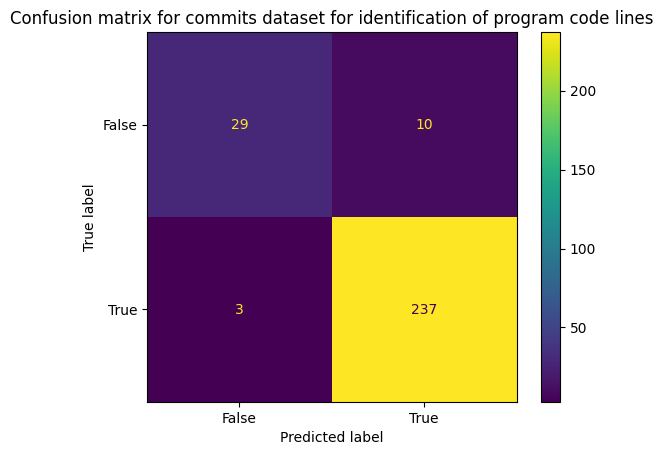

Accuracy score for commits: 0.953405017921147
F-score for commits: 0.973305954825462


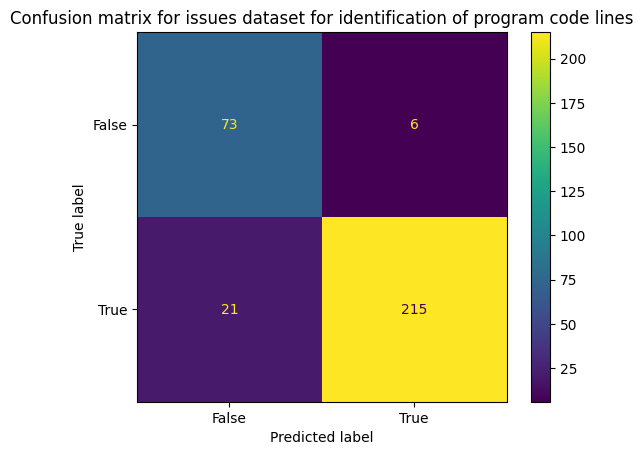

Accuracy score for issues: 0.9142857142857143
F-score for issues: 0.9409190371991247


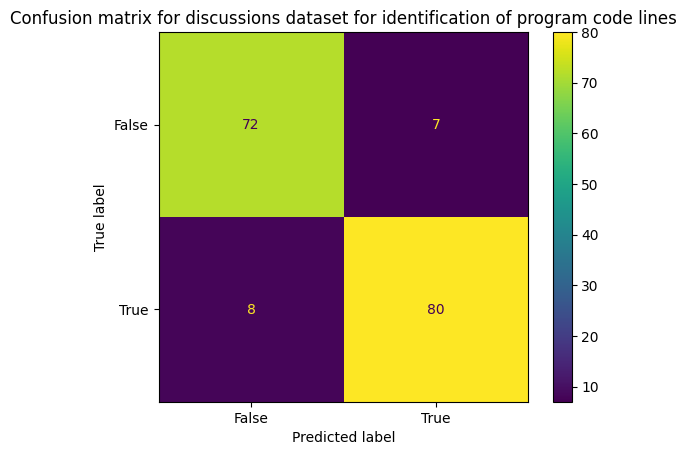

Accuracy score for discussions: 0.9101796407185628
F-score for discussions: 0.9142857142857143


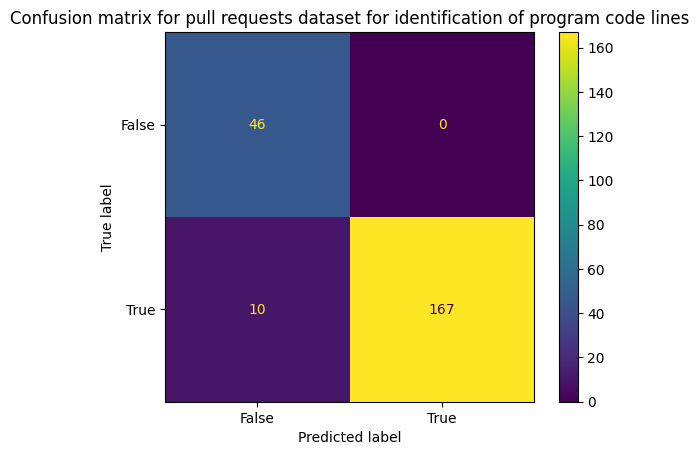

Accuracy score for pull requests: 0.9551569506726457
F-score for pull requests: 0.9709302325581395


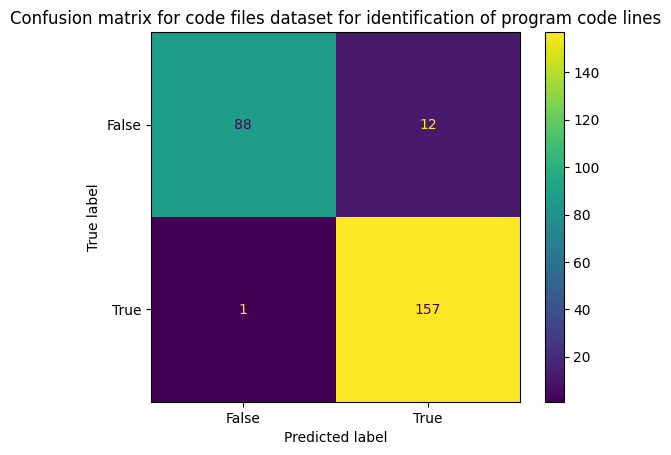

Accuracy score for code files: 0.9496124031007752
F-score for code files: 0.9602446483180428


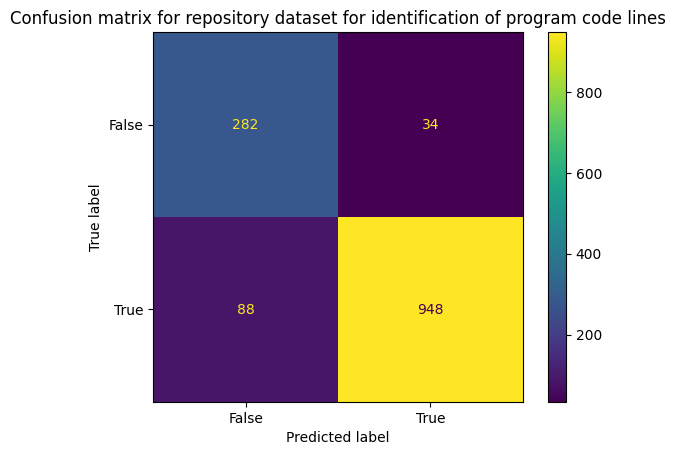

Accuracy score for repository: 0.9097633136094675
F-score for repository: 0.9395441030723488


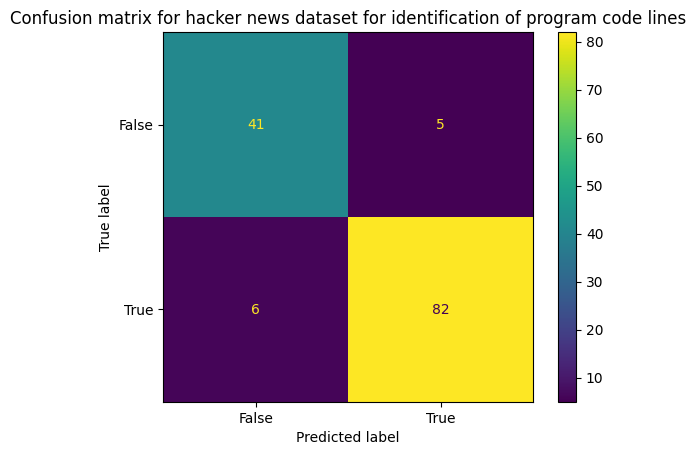

Accuracy score for hacker news: 0.917910447761194
F-score for hacker news: 0.9371428571428572
Total accuracy score: 0.9226539589442815
Total F-score: 0.9470248556364549


In [6]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    y_pred_total = []
    y_true_total = []
    for elem in json_data:
        lines_data = json_data[elem]
        y_pred = [False if line_data['Language'] == 'not_prog' else True for line_data in lines_data]
        y_true = [line_data['is_program'] for line_data in lines_data]
        assert(len(y_pred) == len(y_true))
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[False, True])
        disp.plot()
        plt.title(f"Confusion matrix for {elem} dataset for identification of program code lines")
        plt.show()
        print(f"Accuracy score for {elem}: {accuracy_score(y_true, y_pred)}")
        print(f"F-score for {elem}: {f1_score(y_true, y_pred)}")
        y_pred_total += y_pred
        y_true_total += y_true
    print(f"Total accuracy score: {accuracy_score(y_true_total, y_pred_total)}")
    print(f"Total F-score: {f1_score(y_true_total, y_pred_total)}")
        

In [23]:
with open(programming_language_detector_filename, 'r') as file:
    json_data = json.load(file)
    for elem in json_data:
        lines_data = json_data[elem]
        y_pred_correct = [True if any([line_data['Language'] == 'not_prog' and line_data['is_program'] == False, \
                                       line_data['Language'] != 'not_prog' and line_data['is_program'] == True]) 
                              else False for line_data in lines_data]
        assert(len(lines_data) == len(y_pred_correct))
        for idx, pred in enumerate(y_pred_correct):
            if pred == False:
                line_data = lines_data[idx]
                if line_data['Language'] != 'not_prog' and line_data['is_program'] == False:
                    print(f"False-positive for line: '{line_data['Line']}', predicted {line_data['Language']}, but was not a program.")
                elif line_data['Language'] == 'not_prog' and line_data['is_program'] == True:
                    print(f"False-negative for line: '{line_data['Line']}', predicted not program, but was program.")
                else:
                    continue                

False-positive for line: 'Great! Let's have "prompt/format/shell.md" the default!', predicted prog, but was not a program.
False-positive for line: '- Create new files when needed!', predicted html, but was not a program.
False-positive for line: '- Create a plan!', predicted html, but was not a program.
False-positive for line: 'Installed tools: npm, jq', predicted html, but was not a program.
False-positive for line: 'Files are small, prefer heredoc-ing full files using 'EOF' to prevent substitution.', predicted html, but was not a program.
False-negative for line: 'PM2        | 2023-08-08T23:35:15: PM2 log: App [Mindful AI:0] exited with code [0] via signal [SIGINT]', predicted not program, but was program.
False-negative for line: '0|Mindful  | You have triggered an unhandledRejection, you may have forgotten to catch a Promise rejection:', predicted not program, but was program.
False-negative for line: '0|Mindful  | You have triggered an unhandledRejection, you may have forgotten 

# Data exploration

In [34]:
dataframes = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, repo_dataframe, hackernews_dataframe]
dataframe_names = ["commits", "issues", "discussions", "pull requests", "code files", "repository", "hacker news"]

def count_conv_len_and_word_count(dataframe):
    max_prompt_number = max(dataframe.NumberOfPrompts)
    conversation_lengths_dict = {}
    conv_lengths_list = []
    dataframe_prompt_counter = [0] * max_prompt_number
    dataframe_prompt_lengths_sum = [0] * max_prompt_number
    dataframe_prompt_wordcounts_sum = [0] * max_prompt_number
    for _, df_row in dataframe.iterrows():
        conversations = df_row.Conversations
        for conv_idx in range(len(conversations)):
            prompt = conversations[conv_idx]["Prompt"]
            dataframe_prompt_counter[conv_idx] += 1
            dataframe_prompt_lengths_sum[conv_idx] += len(prompt)
            dataframe_prompt_wordcounts_sum[conv_idx] += len(prompt.split())
    avg_prompt_lengths = [lengths / counter for lengths, counter in zip(dataframe_prompt_lengths_sum, dataframe_prompt_counter)]
    avg_prompt_word_counts = [lengths / counter for lengths, counter in zip(dataframe_prompt_wordcounts_sum, dataframe_prompt_counter)]
    for i in dataframe.NumberOfPrompts:
        conversation_lengths_dict[i] = conversation_lengths_dict.get(i, 0) + 1
        conv_lengths_list.append(i)
    conversation_lengths_dict = dict(sorted(conversation_lengths_dict.items())) # Sort
    return conversation_lengths_dict, conv_lengths_list, avg_prompt_lengths, avg_prompt_word_counts

def plot_histogram_and_prompts_stats(datagrames_list, names):
    stat_pics_dir = "dataset_statistics"

    if not os.path.exists(stat_pics_dir):
        os.mkdir(stat_pics_dir)
    fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30,15), layout="constrained")
    for idx in range(len(datagrames_list)):
        df_row = datagrames_list[idx]
        i,j =  divmod(idx, 4)
        df_filtered = df_row[df_row.NumberOfPrompts <= 30]
        df_filtered.hist(column=["NumberOfPrompts"], bins=30, ax=axs[i,j], grid=False)
        axs[i,j].set_xlabel("Number of prompts")
        axs[i,j].set_ylabel("Number of conversations")
        axs[i,j].set_title(f"Lengths of conversations' sources from {names[idx].capitalize()}.")
        df_tail = df_row[df_row.NumberOfPrompts > 30]
        conv_dictionary, _, _, _ = count_conv_len_and_word_count(df_tail)
        print(f"Conversations sourced from {names[idx].capitalize()} longer than 30 prompts (lenth: count of # of conversations): ", conv_dictionary)
    plt.suptitle("Number of conversations with ≤ 30 prompts.", fontsize=20)
    plt.show()
    fig.savefig(f'{stat_pics_dir}/histograms.png')   # save the figure to file
    plt.close(fig)
    
    stats = [avg_prompt_lengths_list, avg_prompt_word_count_list]
    stats_titles = ["Average prompt length (in symbols)", "Average word count"]
    stats_ylabels = ["Prompt length (in symbols)", "Prompt word count"]
    
    assert(len(stats) == len(stats_titles) == len(stats_ylabels))
    
    for stat_idx, stat in enumerate(stats):
        fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(30,15), layout="constrained")
        plt.xlabel("Prompt number")
        plt.ylabel(f'{stats_ylabels[stat_idx]}')
        for idx in range(len(datagrames_list)):
            i,j =  divmod(idx, 4)
            axs[i,j].set_title(f'{stats_titles[stat_idx]} for {names[idx]} dataset')
            axs[i,j].set_xlabel(f'# of prompt')
            axs[i,j].set_ylabel(stats_ylabels[stat_idx])
            axs[i,j].plot(stat[idx])
        
        plt.show()
        fig.savefig(f'{stat_pics_dir}/prompt_lengths_{str(stat_idx)}.png')   # save the figure to file
        plt.close(fig)

In [35]:
avg_prompt_lengths_list, avg_prompt_word_count_list = [], []
for idx in range(len(dataframes)):
    conv_dictionary, conv_list, avg_prompt_lens, avg_prompt_wc = count_conv_len_and_word_count(dataframes[idx])
    avg_prompt_lengths_list.append(avg_prompt_lens)
    avg_prompt_word_count_list.append(avg_prompt_wc)
    print(f"Statistics for {dataframe_names[idx]} dataframe:")
    print(f"Mean: {np.mean(conv_list)}; median: {np.median(conv_list)}; STD: {np.std(conv_list)}")
    print("Dictionary containing the count of the lengths of the conversations: ", conv_dictionary)
    print("Average prompt lengths for each prompt: ", avg_prompt_lens)
    print("Average word count for each prompt: ", avg_prompt_wc)
    print("=============================================================================")

Statistics for commits dataframe:
Mean: 3.1516203703703702; median: 1.0; STD: 5.636473661551416
Dictionary containing the count of the lengths of the conversations:  {1: 442, 2: 193, 3: 77, 4: 44, 5: 20, 6: 6, 7: 7, 8: 10, 9: 6, 10: 9, 11: 5, 12: 4, 13: 3, 14: 3, 15: 3, 16: 3, 17: 2, 18: 2, 19: 1, 20: 4, 22: 2, 23: 1, 24: 2, 25: 3, 26: 2, 27: 2, 28: 1, 30: 1, 31: 1, 33: 1, 34: 1, 47: 1, 64: 1, 70: 1}
Average prompt lengths for each prompt:  [2729.091435185185, 424.5260663507109, 480.96069868995636, 373.1578947368421, 367.0, 394.18390804597703, 495.1585365853659, 402.72, 628.3692307692307, 827.457627118644, 593.5, 466.1111111111111, 611.1219512195122, 414.6842105263158, 615.4857142857143, 214.65625, 770.0, 197.8148148148148, 543.36, 542.625, 684.35, 231.4, 785.2777777777778, 150.58823529411765, 376.7857142857143, 145.91666666666666, 933.6, 148.75, 243.14285714285714, 156.71428571428572, 170.0, 448.0, 2029.0, 582.75, 370.3333333333333, 1249.0, 68.33333333333333, 520.3333333333334, 52.333

Conversations sourced from Commits longer than 30 prompts (lenth: count of # of conversations):  {31: 1, 33: 1, 34: 1, 47: 1, 64: 1, 70: 1}
Conversations sourced from Issues longer than 30 prompts (lenth: count of # of conversations):  {32: 1, 34: 1, 35: 1, 41: 1, 42: 1, 43: 1, 46: 1, 48: 1, 51: 1, 68: 1, 89: 1, 99: 1, 109: 1, 122: 1}
Conversations sourced from Discussions longer than 30 prompts (lenth: count of # of conversations):  {82: 1}
Conversations sourced from Pull requests longer than 30 prompts (lenth: count of # of conversations):  {32: 1, 34: 1, 38: 1, 49: 1, 51: 1, 167: 1}
Conversations sourced from Code files longer than 30 prompts (lenth: count of # of conversations):  {31: 14, 32: 9, 33: 5, 34: 12, 35: 13, 36: 12, 37: 13, 38: 6, 39: 11, 40: 12, 41: 8, 42: 13, 43: 6, 44: 8, 45: 5, 46: 7, 47: 8, 48: 3, 49: 4, 50: 6, 51: 2, 52: 6, 53: 4, 54: 3, 55: 3, 56: 3, 57: 5, 58: 3, 60: 4, 61: 2, 62: 2, 63: 1, 64: 4, 65: 3, 66: 2, 68: 3, 69: 1, 70: 2, 71: 3, 72: 4, 75: 2, 78: 2, 80: 

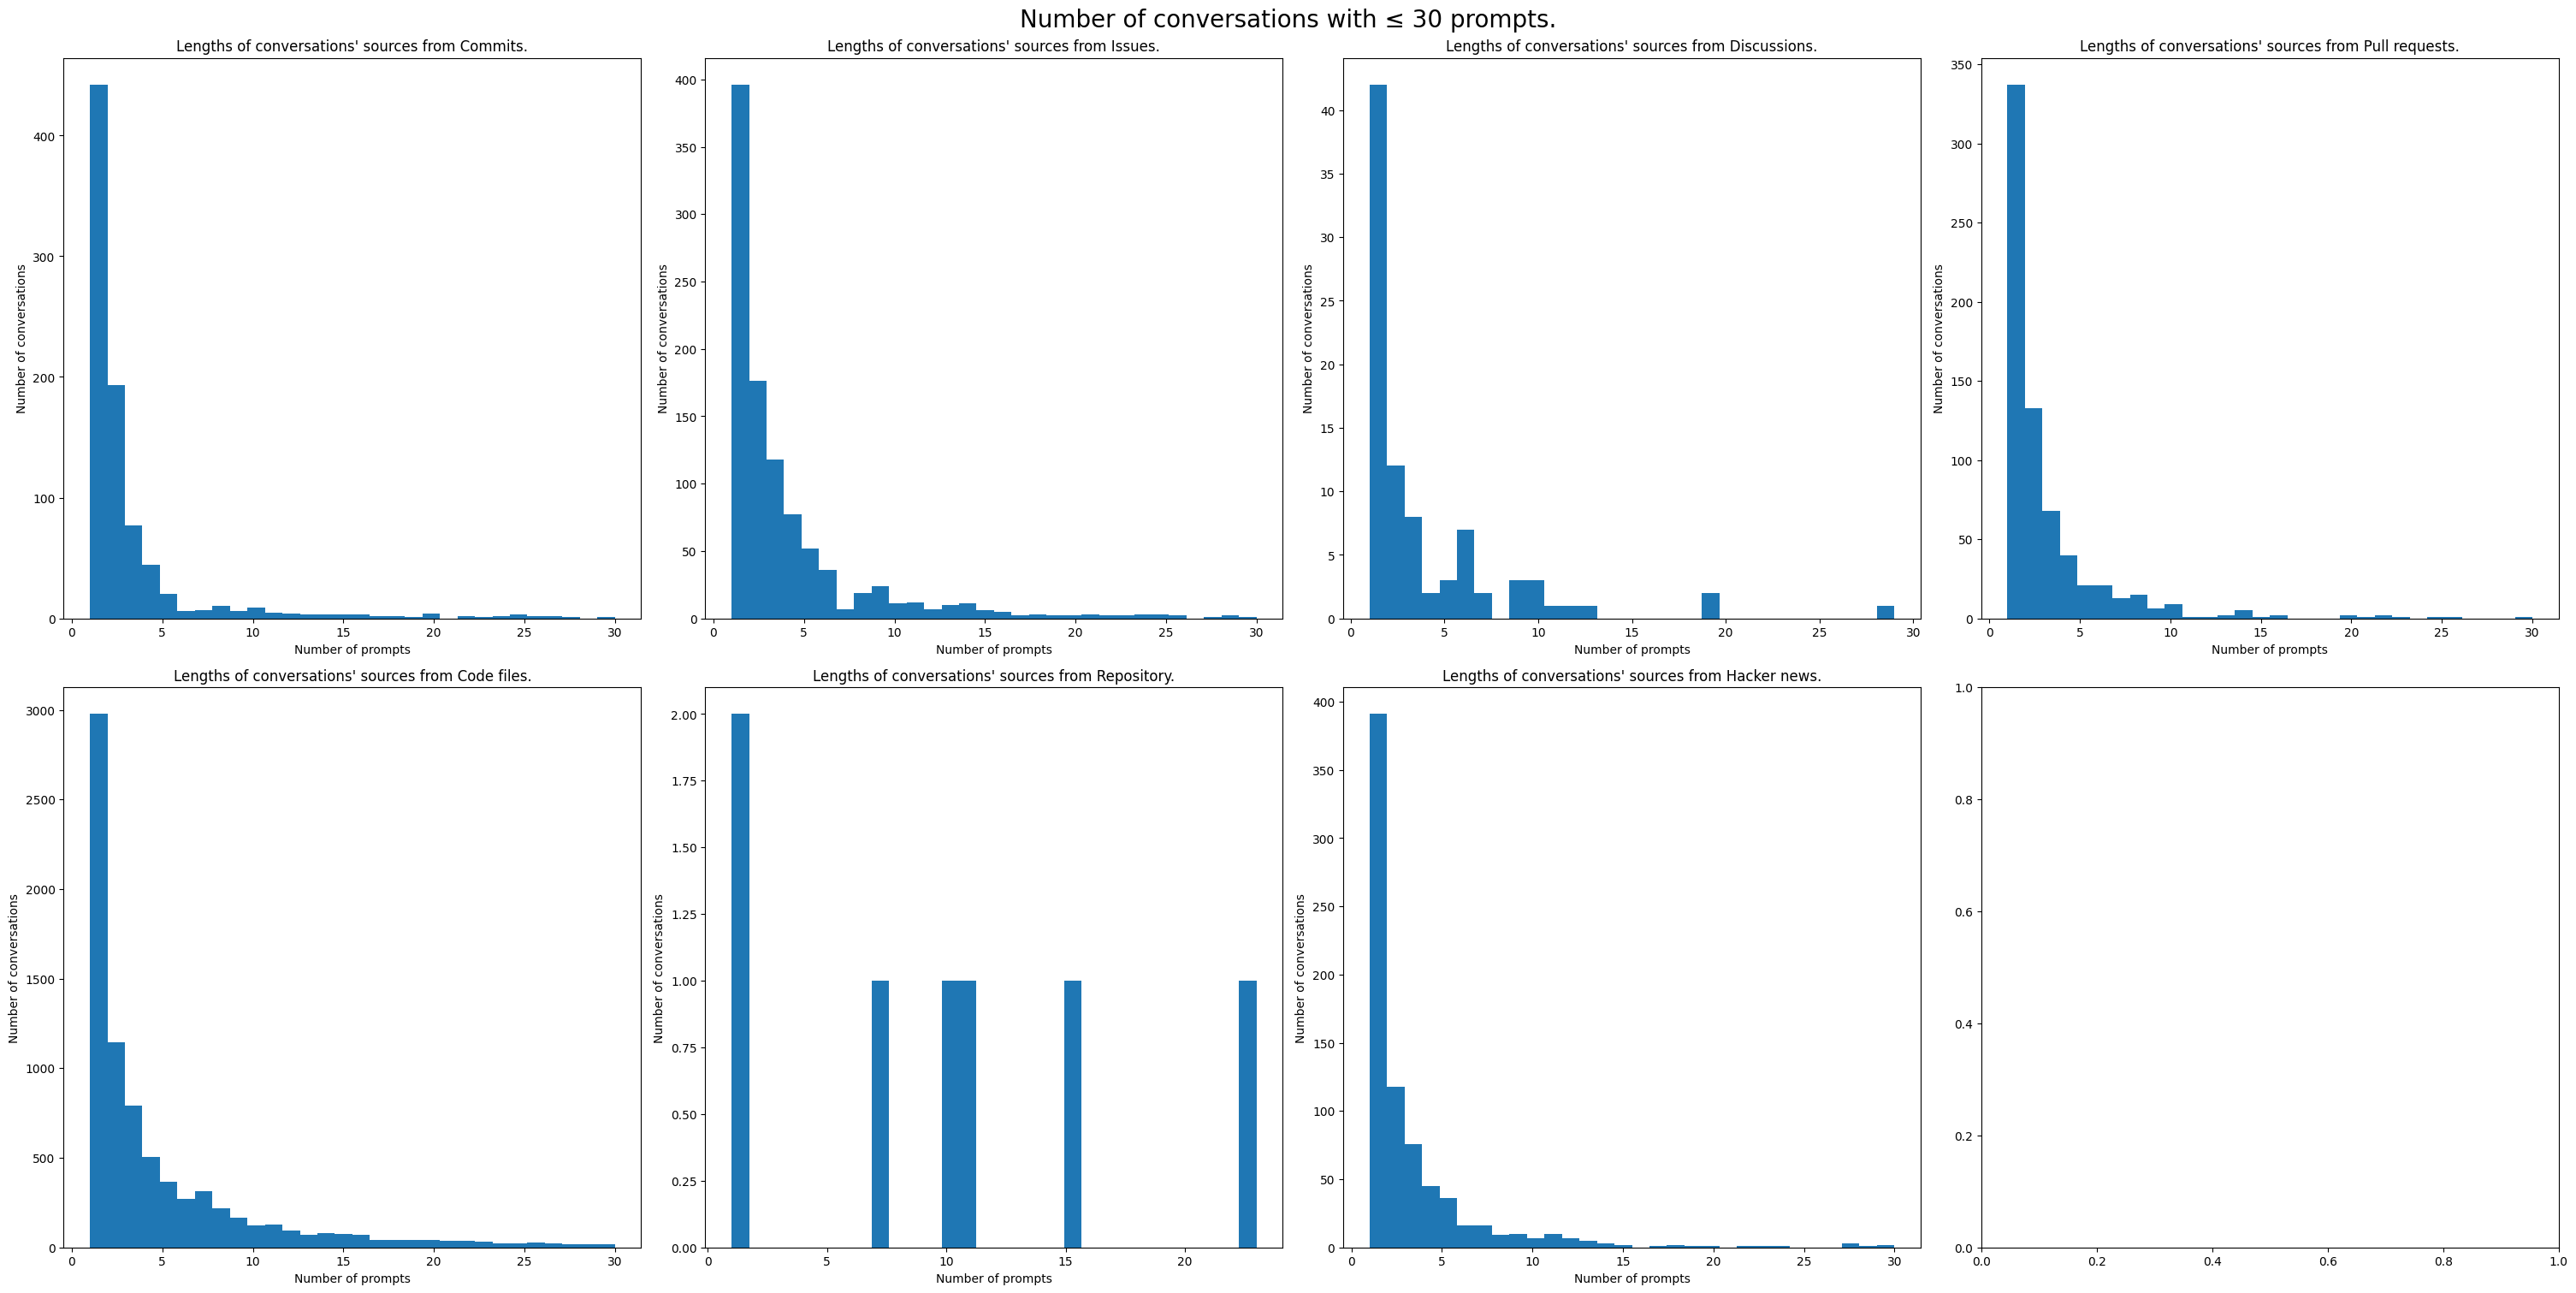

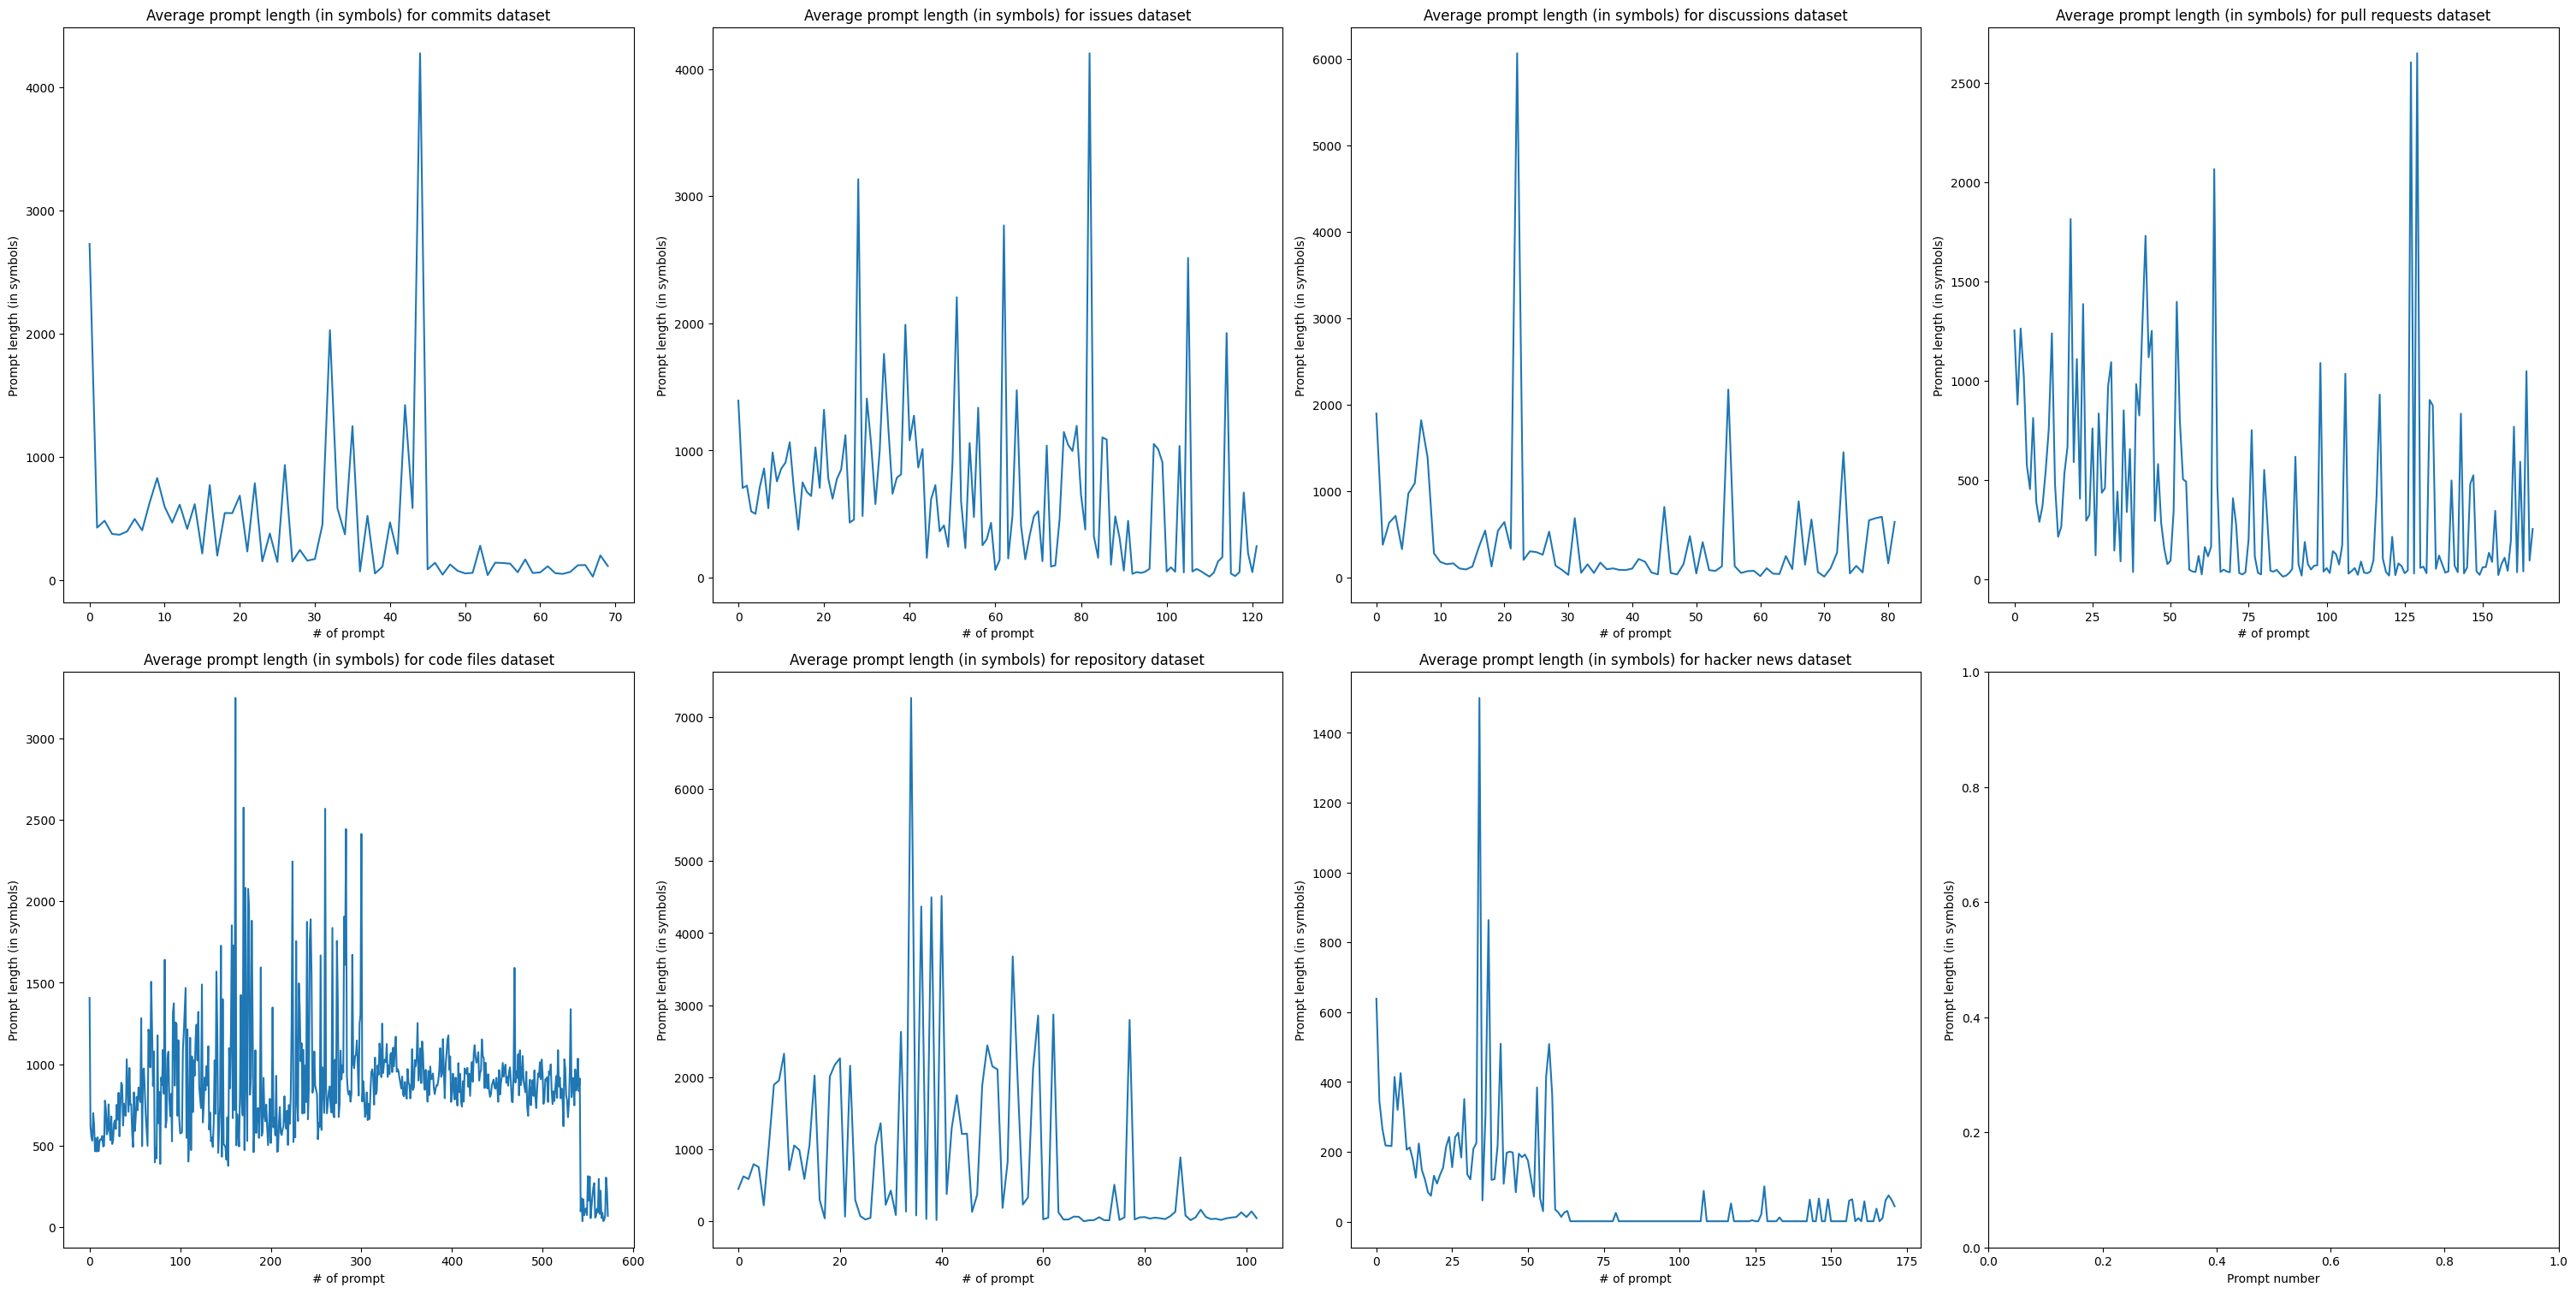

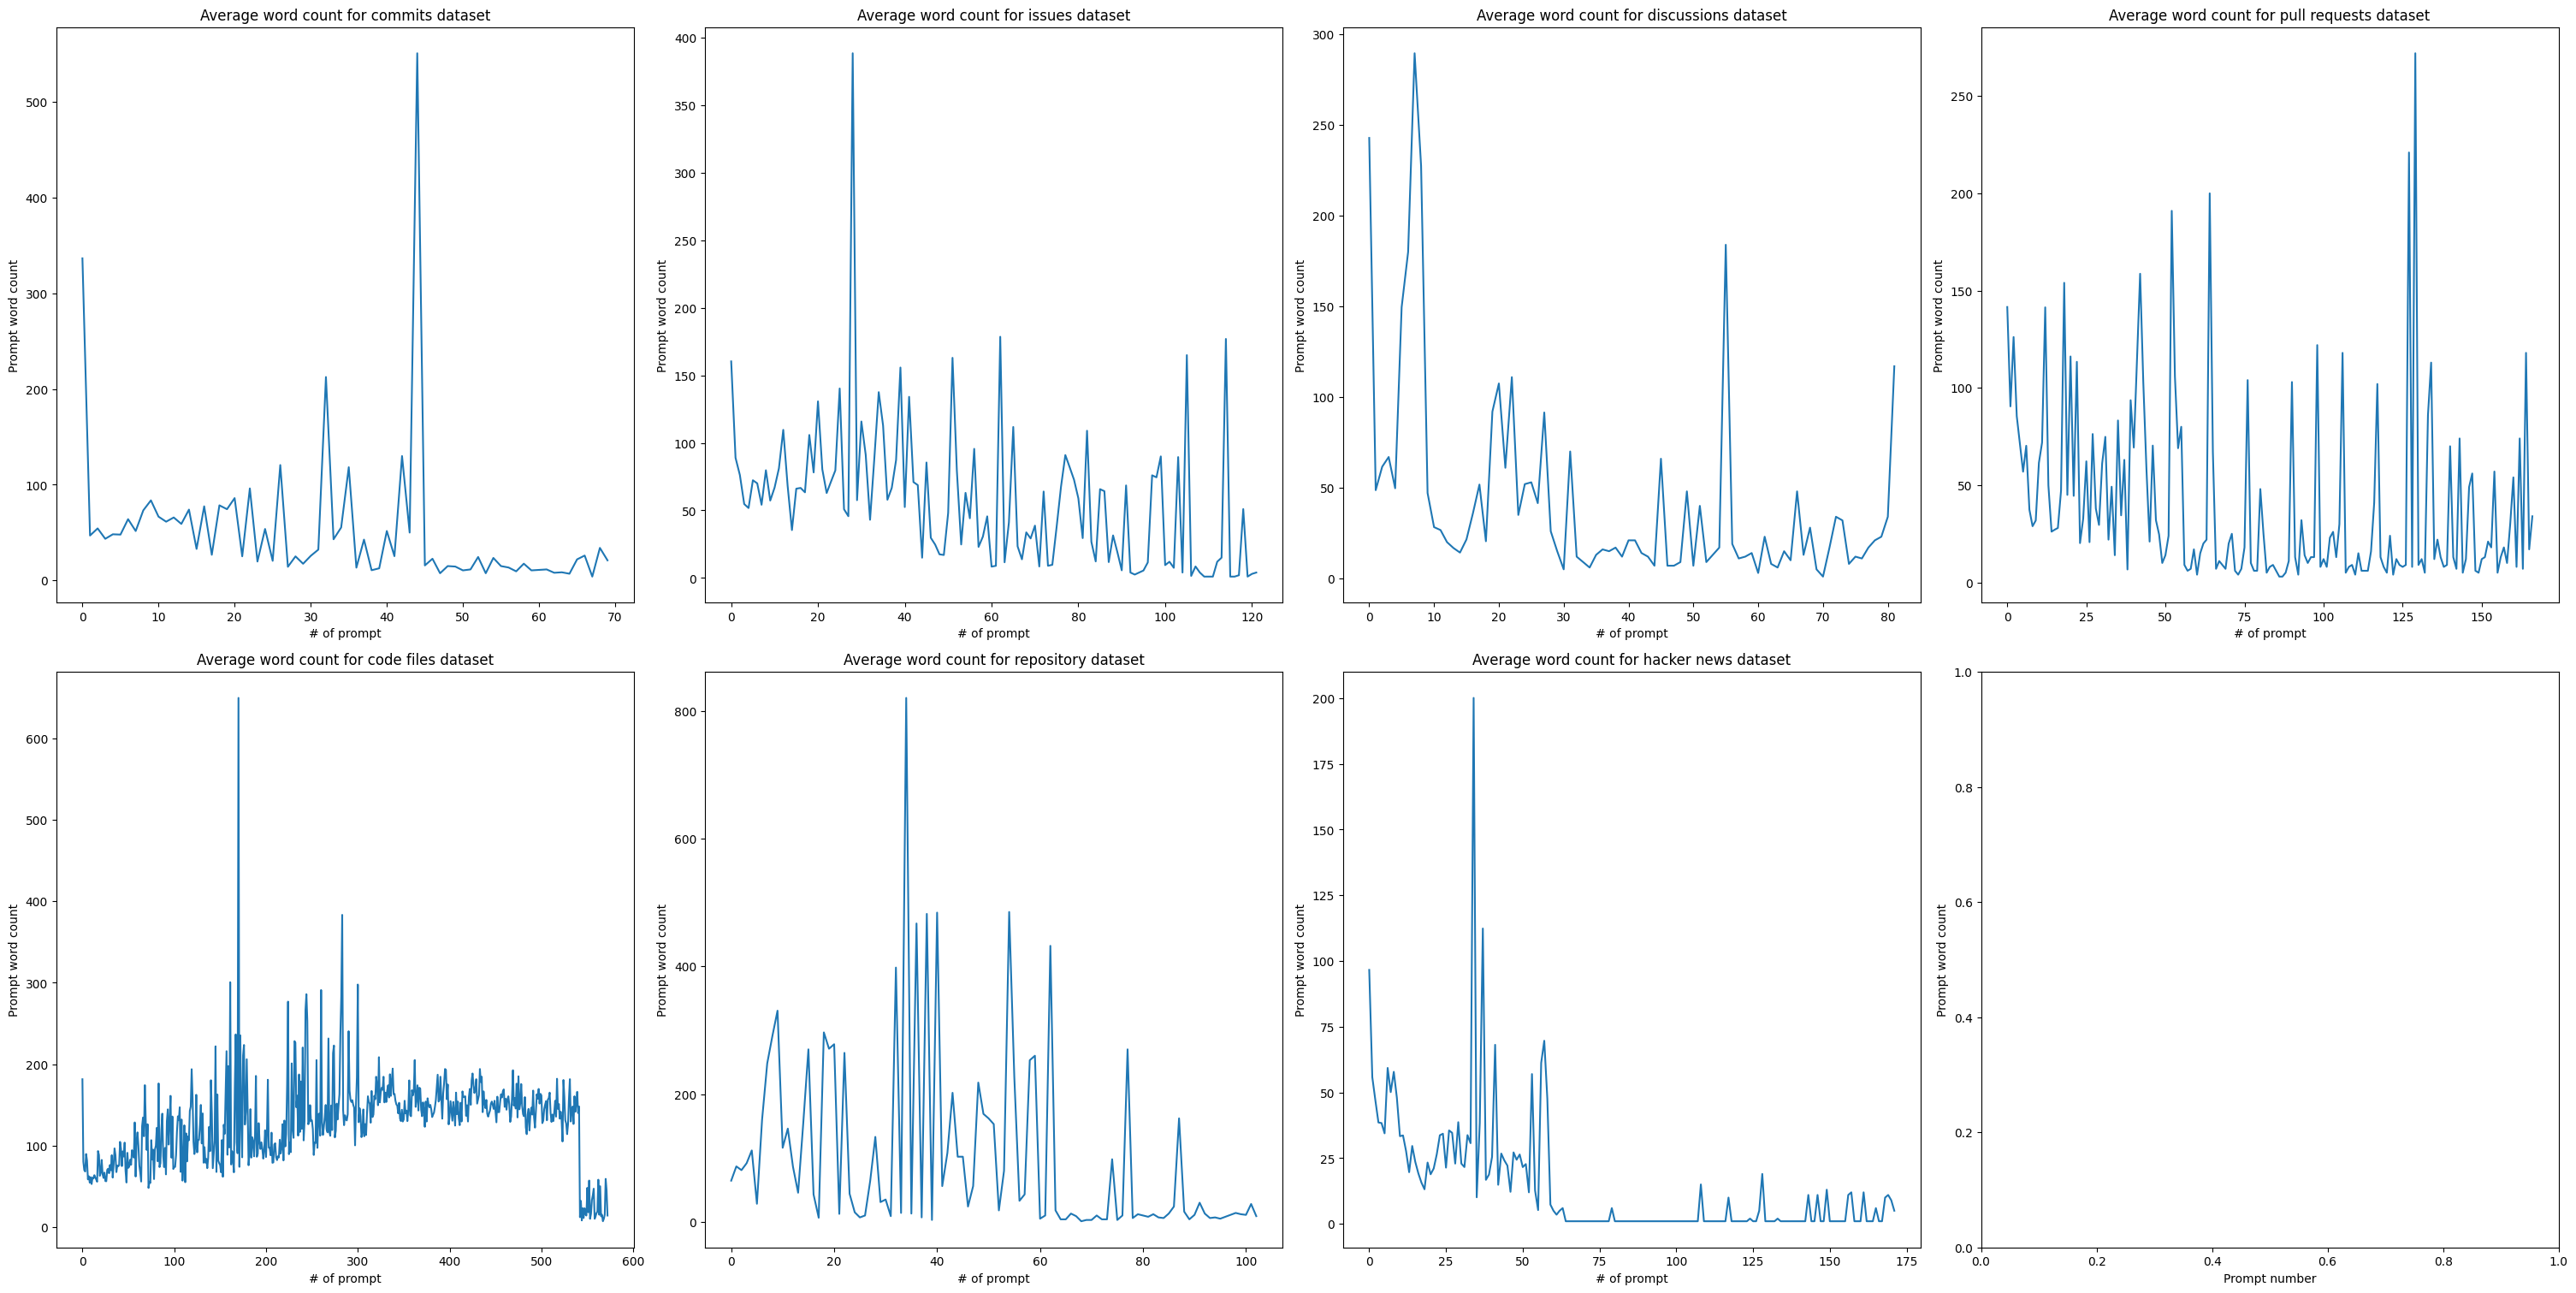

In [36]:
plot_histogram_and_prompts_stats(dataframes, dataframe_names)

# Clean dataframes from the program code

In [25]:
dataframes_cleaned = [commits_dataframe, issues_dataframe, discussions_dataframe, pull_requests_dataframe, code_dataframe, repo_dataframe, hackernews_dataframe]

for idx, dataframe in enumerate(dataframes):
    for index, df_row in dataframe.iterrows():
        conversations = df_row["Conversations"]
        for conv in conversations:
            cleaned_lines = []
            lines_and_languages = detect_programming_languages(conv['Prompt'].split("\n"))
            for (line, language) in lines_and_languages:
                if language == "prog":
                    continue
                else:
                    cleaned_lines.append(line)
            conv['Prompt'] = "\n".join(cleaned_lines)

In [ ]:
plot_histogram_and_prompts_stats(dataframes_cleaned, dataframe_names)

In [119]:
cleaned_dir_name = "cleaned_datasets"

if not os.path.exists(cleaned_dir_name):
    os.mkdir(cleaned_dir_name)

cleaned_dataframe_file_names = [f"{cleaned_dir_name}/cleaned_commits.json", f"{cleaned_dir_name}/cleaned_issues.json", f"{cleaned_dir_name}/cleaned_discussions.json", f"{cleaned_dir_name}/cleaned_pull_requests.json", f"{cleaned_dir_name}/cleaned_code_files.json", f"{cleaned_dir_name}/cleaned_repository.json", f"{cleaned_dir_name}/cleaned_hacker_news.json"]

for i, dataframe in enumerate(dataframes_cleaned):
    dataframe.reset_index(drop=True, inplace=True)
    jso = dataframe.to_json(orient='records')
    with open(cleaned_dataframe_file_names[i], 'w') as file:
        json.dump(json.loads(jso), file)